In [24]:
import numpy as np
print(np.__version__) 
import matplotlib.pyplot as plt 
import scipy.integrate as integrate 
from scipy.integrate import odeint 
import time
from IPython import display 
from matplotlib.patches import Patch 
from matplotlib.lines import Line2D 
import os 
plt.rcParams['axes.titlesize'] = 22 
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 18 
plt.rcParams['axes.titlepad'] = 20 
plt.rcParams['axes.labelpad'] = 16

1.16.4


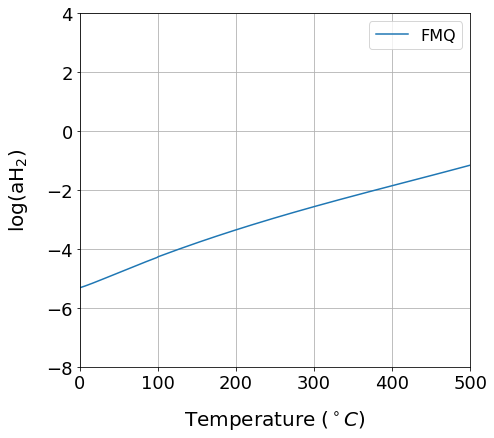

In [25]:
#First let's calculte hydrogen fugacity within our temperature range, 0-500

#The FMQ buffer: 1.5Fe2SiO4 + H2O → Fe3O4 + 1.5SiO2 + H2
#logK = log(aH2) (all other activities are 1)
#T = 0 to 500 in increments of 50 deg C
N, T, P, K_FMQ = np.loadtxt('Europa_K/FMQ_1500bar.txt', skiprows=10, unpack=True)
#K_FMQ = np.array([-2.76355657, -2.39075547, -2.03342326, -1.68463679, -1.33759928, -0.98624673, -0.62674241, -0.26687566, 0.07836855, 0.40244898, 0.70161932])
log_H2 = K_FMQ

FMQ_0 = log_H2[np.where(T==0.01)]
FMQ_100 = log_H2[np.where(T==100)]
FMQ_200 = log_H2[np.where(T==200)]
FMQ_300 = log_H2[np.where(T==300)]
FMQ_400 = log_H2[np.where(T==400)]
FMQ_500 = log_H2[np.where(T==500)]

fig1 = plt.figure(1)
fig1.set_figheight(6.5)
fig1.set_figwidth(7)
plt.clf()
plt.plot(T,log_H2, label = 'FMQ')
plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('log(aH$_2$)')
plt.xlim(0, 500)
plt.ylim(-8,4)
plt.legend(bbox_to_anchor=(1,1), prop={'size': 16})
#plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
plt.grid()
plt.savefig('Speciation_Plots/Carbon/logH2_FMQ.png', bbox_inches = 'tight')
plt.show()

In [26]:
#Ox state figure


In [27]:
#Calculate pH neutral
fname = 'Europa_K/Kw_1500bar.txt'
N, T, P, Kw = np.loadtxt(fname, skiprows=8, unpack=True)
pH_neutral = -0.5*Kw #function of T

pHn_0 = pH_neutral[np.where(T==0.01)]
pHn_100 = pH_neutral[np.where(T==100)]
pHn_200 = pH_neutral[np.where(T==200)]
pHn_300 = pH_neutral[np.where(T==300)]
pHn_400 = pH_neutral[np.where(T==400)]
pHn_500 = pH_neutral[np.where(T==500)]

In [28]:
#Calculate total carbon and nitrogen
M_H2O = 18.015/1000 #kg/mol

#Marty paper: CI-CM chondrites:
f_C = 2.94e-3 #mol/g rock
f_N = 1.09e-4
f_H2O = 6.60e-3

#Sigma_C = f_C/(f_H2O*M_H2O) #mol C/kg H2O
#Sigma_N = f_N/(f_H2O*M_H2O)

#Earth: mid-ocean ridge
#fC_E = 1.67e-6 #mol/g
#fH2O_E = 8.33e-6
#SigmaC_E = fC_E/(fH2O_E*M_H2O)

#Earth: bulk mantle:
#fC_EBM = 6.38e-5
#fH2O_EBM = 2.0e-4
#SigmaC_EBM = fC_EBM/(fH2O_EBM*M_H2O)


In [29]:
#Define a function to calculate intersection point of two lines
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(x1,y1,x2,y2):
    p1 = [x1[0],y1[0]]
    p2 = [x1[1],y1[1]]
    p3 = [x2[0],y2[0]]
    p4 = [x2[1],y2[1]]
    L1 = line(p1,p2)
    L2 = line(p3,p4)
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = np.round((Dx / D), decimals = 3)
        y = np.round((Dy / D), decimals = 3)
        return x,y
    else:
        return False

In [30]:
#Plot stable carbon species at T = 500, P = 1500 bar
pH = np.arange(0,15,0.05)
T = np.array([0, 100, 200, 300, 400, 500])

#1) CH4 + 2H2O -> CO2 + 4H2
K1 = np.array([-39.090765, -26.718334, -18.275548, -12.0572392, -7.1543566, -3.0214712])
aH2_1 = 0.25*K1
y1 = np.zeros([len(T), len(pH)])
for i in range(0,len(T)):
    y1[i,:] = aH2_1[i] #for calculating intersection point

#2) CH4 + 3H2O -> HCO3- + H+ + 4H2
K2 = np.array([-44.95005, -32.53796, -24.82593, -19.62016, -15.93122, -13.25445])
aH2_2 = np.zeros([len(T), len(pH)])
for i in range(0,len(T)):
    aH2_2[i] = 0.25*(K2[i] + pH)

#3) CH4 + 3H2O -> CO3-2 + 2H+ + 4H2
K3 = ([-54.58320, -42.22946, -34.66177, -29.85526, -26.72606, -24.67597])
aH2_3 = np.zeros([len(T), len(pH)])
for i in range(0,len(T)):
    aH2_3[i] = 0.25*(K3[i] + 2*pH)

#5) H+ + HCO3- -> CO2 + H2O
K5 = np.array([5.859284, 5.819622, 6.550380, 7.562921, 8.776868, 10.232979])
pH_5 = K5

#6) HCO3 -> H+ + CO3
K6 = np.array([-9.633148, -9.691505, -9.835843, -10.23510, -10.79483, -11.42152])
pH_6 = -K6

#7) H2O + CO2 -> CO3-2 + 2H+
K7 = np.array([-15.49243, -15.51113, -16.38622, -17.79802, -19.57170, -21.65450])
pH_7 = -0.5*K7

#Intersection points:
x_12 = np.zeros(len(T))
y_12 = np.zeros(len(T))
x_23 = np.zeros(len(T))
y_23 = np.zeros(len(T))

for i in range (0,len(T)):
    x_12[i],y_12[i] = intersection(pH,y1[i],pH,aH2_2[i])
    x_23[i],y_23[i] = intersection(pH,aH2_2[i],pH,aH2_3[i])

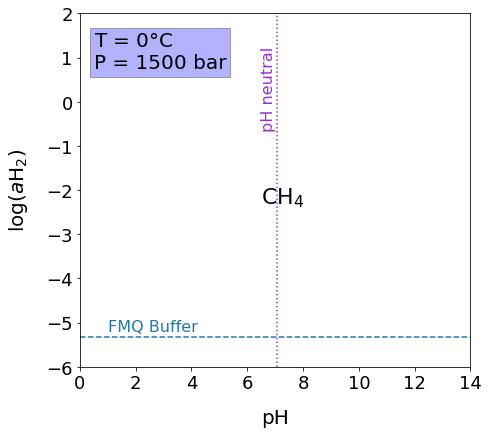

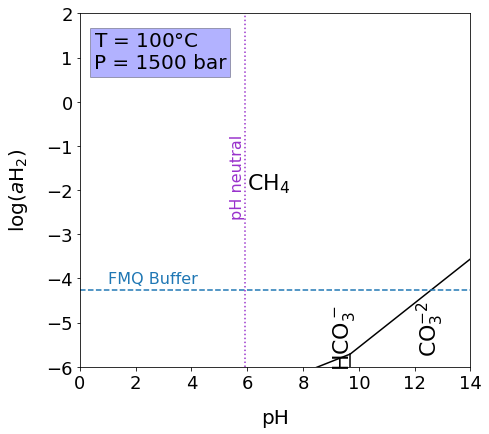

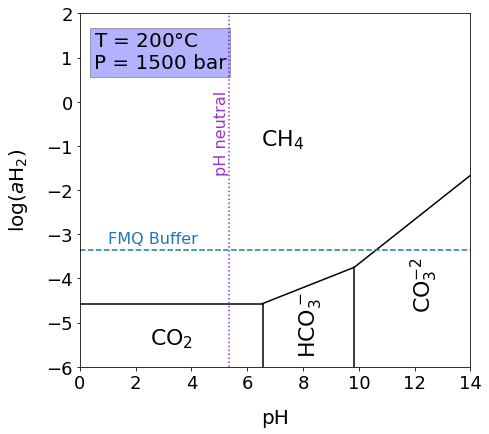

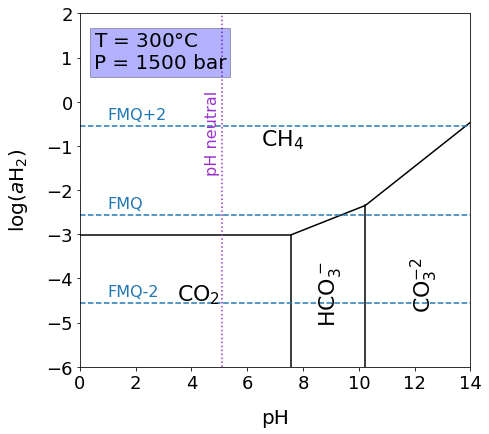

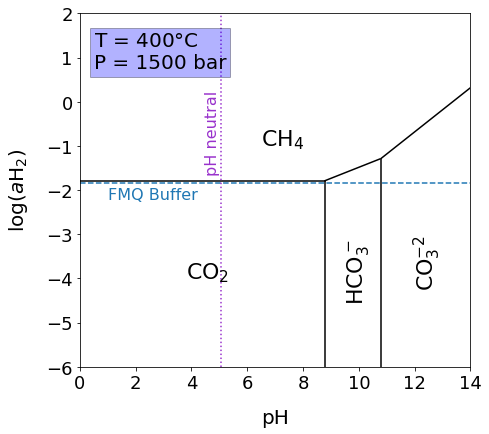

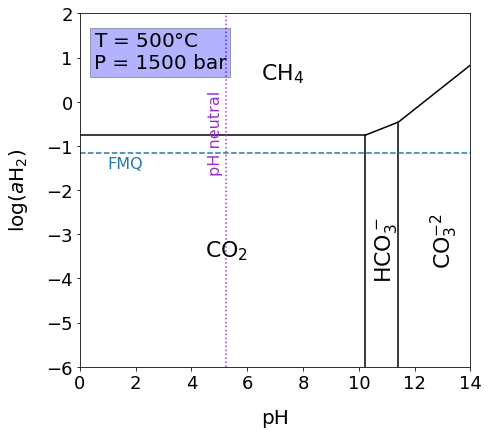

In [31]:
#T = 0
fig2 = plt.figure(2)
fig2.set_figheight(6.5)
fig2.set_figwidth(7)
plt.clf()
#CH4 -> CO2
plt.plot([0,pH_5[0]],[aH2_1[0],aH2_1[0]], label = r'CH$_4 \rightarrow$ CO$_2$', color = 'k')
#CH4 -> HCO3
pH_2 = pH[pH>x_12[0]]
aH2_2_new = aH2_2[0][aH2_2[0]>y_12[0]]
plt.plot(pH_2[pH_2<x_23[0]], aH2_2_new[aH2_2_new<y_23[0]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CH4 -> HCO3
plt.plot(pH[pH>x_23[0]], aH2_3[0][aH2_3[0]>y_23[0]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CO2 -> HCO3
plt.plot([pH_5[0], pH_5[0]], [-7,aH2_1[0]], label = r'CO$_2 \rightarrow$ HCO$_3^-$', color = 'k')
#HCO3 -> CO3-2
plt.plot([pH_6[0], pH_6[0]], [-7,y_23[0]], label = r'HCO$_3 \rightarrow$ CO$_3^-$', color = 'k')
#Labels:
plt.text(6.5,-2.3, 'CH$_4$', size=22)
#FMQ buffer
plt.axhline(y=FMQ_0,linestyle='--')
plt.text(1,-5.2,'FMQ Buffer', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_0, linestyle = ':', color = 'darkorchid')
plt.text(6.5,1,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
plt.text(0.5, 0.75, 'T = 0$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,2)
plt.ylabel('log($a$H$_2$)')
plt.savefig('Speciation_Plots/Carbon/activity_0', bbox_inches = 'tight')

# #T = 100
fig3 = plt.figure(3)
fig3.set_figheight(6.5)
fig3.set_figwidth(7)
plt.clf()
#CH4 -> CO2
plt.plot([0,pH_5[1]],[aH2_1[1],aH2_1[1]], label = r'CH$_4 \rightarrow$ CO$_2$', color = 'k')
#CH4 -> HCO3
pH_2 = pH[pH>x_12[1]]
aH2_2_new = aH2_2[1][aH2_2[1]>y_12[1]]
plt.plot(pH_2[pH_2<x_23[1]], aH2_2_new[aH2_2_new<y_23[1]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CH4 -> HCO3
plt.plot(pH[pH>x_23[1]], aH2_3[1][aH2_3[1]>y_23[1]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CO2 -> HCO3
plt.plot([pH_5[1], pH_5[1]], [-7,aH2_1[1]], label = r'CO$_2 \rightarrow$ HCO$_3^-$', color = 'k')
#HCO3 -> CO3-2
plt.plot([pH_6[1], pH_6[1]], [-7,y_23[1]], label = r'HCO$_3 \rightarrow$ CO$_3^-$', color = 'k')
#Labels:
plt.text(6,-2, 'CH$_4$', size=22)
plt.text(0.5, 0.75, 'T = 100$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
#plt.text(3,-4, 'CO$_2$', size=22)
plt.text(9,-5, 'HCO$_3^-$', size=22, rotation=90)
plt.text(12,-5, 'CO$_3^{-2}$', size=22, rotation=90)
#FMQ buffer
plt.axhline(y=FMQ_100,linestyle='--')
plt.text(1,-4.1,'FMQ Buffer', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_100, linestyle = ':', color = 'darkorchid')
plt.text(5.4,-1,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,2)
plt.ylabel('log($a$H$_2$)')
plt.savefig('Speciation_Plots/Carbon/activity_100', bbox_inches = 'tight')

#T = 200
fig4 = plt.figure(4)
fig4.set_figheight(6.5)
fig4.set_figwidth(7)
plt.clf()
#CH4 -> CO2
plt.plot([0,pH_5[2]],[aH2_1[2],aH2_1[2]], label = r'CH$_4 \rightarrow$ CO$_2$', color = 'k')
#CH4 -> HCO3
pH_2 = pH[pH>x_12[2]]
aH2_2_new = aH2_2[2][aH2_2[2]>y_12[2]]
plt.plot(pH_2[pH_2<x_23[2]], aH2_2_new[aH2_2_new<y_23[2]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CH4 -> HCO3
plt.plot(pH[pH>=x_23[2]], aH2_3[2][aH2_3[2]>y_23[2]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CO2 -> HCO3
plt.plot([pH_5[2], pH_5[2]], [-7,aH2_1[2]], label = r'CO$_2 \rightarrow$ HCO$_3^-$', color = 'k')
#HCO3 -> CO3-2
plt.plot([pH_6[2], pH_6[2]], [-7,y_23[2]], label = r'HCO$_3 \rightarrow$ CO$_3^-$', color = 'k')
#Labels:
plt.text(6.5,-1, 'CH$_4$', size=22)
plt.text(2.5, -5.5, 'CO$_2$', size=22)
plt.text(7.8,-4.7, 'HCO$_3^-$', size=22, rotation=90)
plt.text(11.8,-4, 'CO$_3^{-2}$', size=22, rotation=90)
plt.text(0.5, 0.75, 'T = 200$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
#FMQ buffer
plt.axhline(y=FMQ_200,linestyle='--')
plt.text(1,-3.2,'FMQ Buffer', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_200, linestyle = ':', color = 'darkorchid')
plt.text(4.8,0,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,2)
plt.ylabel('log($a$H$_2$)')
plt.savefig('Speciation_Plots/Carbon/activity_200', bbox_inches = 'tight')

#T = 300
fig5 = plt.figure(5)
fig5.set_figheight(6.5)
fig5.set_figwidth(7)
plt.clf()
#CH4 -> CO2
plt.plot([0,pH_5[3]],[aH2_1[3],aH2_1[3]], label = r'CH$_4 \rightarrow$ CO$_2$', color = 'k')
#CH4 -> HCO3
pH_2 = pH[pH>x_12[3]]
aH2_2_new = aH2_2[3][aH2_2[3]>y_12[3]]
plt.plot(pH_2[pH_2<x_23[3]], aH2_2_new[aH2_2_new<y_23[3]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CH4 -> CO3
plt.plot(pH[pH>=x_23[3]], aH2_3[3][aH2_3[3]>y_23[3]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CO2 -> HCO3
plt.plot([pH_5[3], pH_5[3]], [-7,aH2_1[3]], label = r'CO$_2 \rightarrow$ HCO$_3^-$', color = 'k')
#HCO3 -> CO3-2
plt.plot([pH_6[3], pH_6[3]], [-7,y_23[3]], label = r'HCO$_3 \rightarrow$ CO$_3^-$', color = 'k')
#Labels:
plt.text(6.5,-1, 'CH$_4$', size=22)
plt.text(3.5, -4.5, 'CO$_2$', size=22)
plt.text(8.5,-4, 'HCO$_3^-$', size=22, rotation=90)
plt.text(11.8,-4, 'CO$_3^{-2}$', size=22, rotation=90)
plt.text(0.5, 0.75, 'T = 300$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
#FMQ buffer
plt.axhline(y=FMQ_300,linestyle='--')
plt.axhline(y=FMQ_300+2,linestyle='--')
plt.axhline(y=FMQ_300-2,linestyle='--')
plt.text(1,-2.4,'FMQ', size=16, color = '#1f77b4')
plt.text(1,-0.4,'FMQ+2', size=16, color = '#1f77b4')
plt.text(1,-4.4,'FMQ-2', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_300, linestyle = ':', color = 'darkorchid')
plt.text(4.5,0,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,2)
plt.ylabel('log($a$H$_2$)')
plt.savefig('Speciation_Plots/Carbon/activity_300', bbox_inches = 'tight')

#T = 400
fig6 = plt.figure(6)
fig6.set_figheight(6.5)
fig6.set_figwidth(7)
plt.clf()
#CH4 -> CO2
plt.plot([0,pH_5[4]],[aH2_1[4],aH2_1[4]], label = r'CH$_4 \rightarrow$ CO$_2$', color = 'k')
#CH4 -> HCO3
pH_2 = pH[pH>x_12[4]]
aH2_2_new = aH2_2[4][aH2_2[4]>y_12[4]]
plt.plot(pH_2[pH_2<x_23[4]], aH2_2_new[aH2_2_new<y_23[4]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CH4 -> CO3
plt.plot(pH[pH>=x_23[4]], aH2_3[4][aH2_3[4]>y_23[4]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CO2 -> HCO3
plt.plot([pH_5[4], pH_5[4]], [-7,aH2_1[4]], label = r'CO$_2 \rightarrow$ HCO$_3^-$', color = 'k')
#HCO3 -> CO3-2
plt.plot([pH_6[4], pH_6[4]], [-7,y_23[4]], label = r'HCO$_3 \rightarrow$ CO$_3^-$', color = 'k')
#Labels:
plt.text(6.5,-1, 'CH$_4$', size=22)
plt.text(3.8, -4, 'CO$_2$', size=22)
plt.text(9.5,-3.5, 'HCO$_3^-$', size=22, rotation=90)
plt.text(11.9,-3.5, 'CO$_3^{-2}$', size=22, rotation=90)
plt.text(0.5, 0.75, 'T = 400$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
#FMQ buffer
plt.axhline(y=FMQ_400,linestyle='--')
plt.text(1,-2.2,'FMQ Buffer', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_400, linestyle = ':', color = 'darkorchid')
plt.text(4.5,0,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,2)
plt.ylabel('log($a$H$_2$)')
plt.savefig('Speciation_Plots/Carbon/activity_400', bbox_inches = 'tight')

#T = 500
fig7 = plt.figure(7)
fig7.set_figheight(6.5)
fig7.set_figwidth(7)
plt.clf()
#CH4 -> CO2
plt.plot([0,pH_5[5]],[aH2_1[5],aH2_1[5]], label = r'CH$_4 \rightarrow$ CO$_2$', color = 'k')
#CH4 -> HCO3
pH_2 = pH[pH>x_12[5]]
aH2_2_new = aH2_2[5][aH2_2[5]>y_12[5]]
plt.plot(pH_2[pH_2<x_23[5]], aH2_2_new[aH2_2_new<y_23[5]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CH4 -> CO3
plt.plot(pH[pH>=x_23[5]], aH2_3[5][aH2_3[5]>y_23[5]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CO2 -> HCO3
plt.plot([pH_5[5], pH_5[5]], [-7,aH2_1[5]], label = r'CO$_2 \rightarrow$ HCO$_3^-$', color = 'k')
#HCO3 -> CO3-2
plt.plot([pH_6[5], pH_6[5]], [-7,y_23[5]], label = r'HCO$_3 \rightarrow$ CO$_3^-$', color = 'k')
#Labels:
plt.text(6.5,0.5, 'CH$_4$', size=22)
plt.text(4.5, -3.5, 'CO$_2$', size=22)
plt.text(10.5,-3, 'HCO$_3^-$', size=22, rotation=90)
plt.text(12.5,-3, 'CO$_3^{-2}$', size=22, rotation=90)
plt.text(0.5, 0.75, 'T = 500$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
#FMQ buffer
plt.axhline(y=FMQ_500,linestyle='--')
plt.text(1,-1.5,'FMQ', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_500, linestyle = ':', color = 'darkorchid')
plt.text(4.6,0,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,2)
plt.ylabel('log($a$H$_2$)')
plt.savefig('Speciation_Plots/Carbon/activity_500', bbox_inches = 'tight')

plt.show()

In [32]:
#function to convert celcius to kelvin
def C_to_K(T_C):
    T_K = T_C+273.15
    return T_K

In [33]:
#oxidation state values: changing the temp range to what Chris suggested
#The FMQ buffer: 1.5Fe2SiO4 + H2O → Fe3O4 + 1.5SiO2 + H2
#logK = log(aH2) (all other activities are 1)
#N, T, P, logK_FMQ = np.loadtxt('Europa_K/FMQ_1500bar.txt', skiprows=10, unpack=True)
N, T, P, logK_FMQ = np.loadtxt('Europa_K/FMQ_1500bar_newT.txt', skiprows=10, max_rows=81, unpack=True)
aH2 = np.zeros([3,len(T)])
aH2[0] = logK_FMQ-2 #FMQ
aH2[1] = logK_FMQ #PPM
aH2[2] = logK_FMQ+2 #IW

#Note that all of these should be log values!
#Convert aH2 to aO2:
#2H2 + O2 -> 2H2O
#logK = -2log[H2] - log[O2] 
#N, T, P, logK_O2 = np.loadtxt('Europa_K/O2.txt', skiprows=8, unpack=True)
N, T, P, logK_O2 = np.loadtxt('Europa_K/O2_newT.txt', skiprows=8, max_rows=81, unpack=True)
aO2 = np.zeros([3,len(logK_FMQ )])
aO2[0] = -logK_O2 - 2*aH2[0]
aO2[1] = -logK_O2 - 2*aH2[1]
aO2[2] = -logK_O2 - 2*aH2[2]

#Convert aO2 to fO2 for comparison to analog vals:
#O2(aq) -> O2(g)
#logK = log(fO2) - log(aO2)
#lof(fO2) = logK + log(aO2)
#N, T, P, logK_fO2 = np.loadtxt('Europa_K/O2_fug.txt', skiprows=7, unpack=True)
N, T, P, logK_fO2 = np.loadtxt('Europa_K/O2_fug_newT.txt', skiprows=7, max_rows = 81, unpack=True)
fO2 = np.zeros([3,len(logK_FMQ )])
fO2[0] = logK_fO2 + aO2[0]
fO2[1] = logK_fO2 + aO2[1]
fO2[2] = logK_fO2 + aO2[2]

# #Also convert aH2 to fH2:
# N, T, P, logK_H2 = np.loadtxt('Europa_K/H2_fug.txt', skiprows=7, unpack=True)
# fH2 = np.zeros([3,len(logK_FMQ )])
# fH2[0] = logK_H2 + aH2[0]
# fH2[1] = logK_H2 + aH2[1]
# fH2[2] = logK_H2 + aH2[2]

#For converting fO2s to aH2s
#N, T, P, logK_fO2toaH2 = np.loadtxt('Europa_K/meteorite_fO2toaH2.txt', skiprows=8, max_rows=501, unpack=True)
N, T, P, logK_fO2toaH2 = np.loadtxt('Europa_K/meteorite_fO2toaH2_newT.txt', skiprows=8, max_rows=81, unpack=True)

#PPM:
#N, T, P, logK_PPM = np.loadtxt('Europa_K/PPM_fO2.txt', skiprows=9, max_rows=501, unpack=True)
N, T_PPM, P, logK_PPM = np.loadtxt('Europa_K/PPM_fO2_newT.txt', skiprows=9, max_rows=75, unpack=True)
fO2_PPM = -logK_PPM
aH2_PPM = 0.5*(-logK_fO2toaH2[0:75] - fO2_PPM)

#IW:
#N, T, P, logK_IW = np.loadtxt('Europa_K/IW_fO2.txt', skiprows=8, max_rows=501, unpack=True)
N, T_IW, P, logK_IW = np.loadtxt('Europa_K/IW_fO2_newT.txt', skiprows=8, max_rows=96, unpack=True)

fO2_IW = -logK_IW
aH2_IW = 0.5*(-logK_fO2toaH2 - fO2_IW[0:81])

#Reproduce analog values

#Schaefer & Fegley:
def met_fit(T, a,b,c,d,f):
    fO2 = a + (b*(1e3)/T) + (c*(1e6)/(T**2)) + (d*(1e9)/(T**3)) + (f*(1e12)/(T**4))
    return fO2

#Constants from paper: CI, CV, H, EH, Euc
a = np.array([2.4976, 9.0621, 5.0743, 4.9495, 5.4856])
b = np.array([-9.8605, -31.193, -22.906, -24.024, -25.127])
c = np.array([-17.0701, 5.1092, -5.6610, -4.6236, -3.6580])
d = np.array([7.5220, -1.8475, 2.0634, 1.7177, 1.3014])
f = np.array([-1.0404, 0.2000, -0.2618, -0.2332, -0.1650])

fO2_CI = met_fit(C_to_K(T),a[0],b[0],c[0],d[0],f[0])
fO2_CV = met_fit(C_to_K(T),a[1],b[1],c[1],d[1],f[1])
fO2_H = met_fit(C_to_K(T),a[2],b[2],c[2],d[2],f[2])
fO2_EH = met_fit(C_to_K(T),a[3],b[3],c[3],d[3],f[3])
fO2_Euc = met_fit(C_to_K(T),a[4],b[4],c[4],d[4],f[4])

#Convert these to aH2: O2(g) + 2H2(aq) -> 2H2O(liq)
#K = -2(fH2) - fO2 -> fH2 = 0.5*(-K - fO2) (1500 bar)
#N, T, P, logK_aH2 = np.loadtxt('Europa_K/meteorite_aH2.txt', skiprows=8, unpack=True)
aH2_CI = 0.5*(-logK_fO2toaH2 - fO2_CI[0:81])
aH2_CV = 0.5*(-logK_fO2toaH2 - fO2_CV[0:81])
aH2_H = 0.5*(-logK_fO2toaH2 - fO2_H[0:81])
aH2_EH = 0.5*(-logK_fO2toaH2 - fO2_EH[0:81])
aH2_Euc = 0.5*(-logK_fO2toaH2 - fO2_Euc[0:81])


In [34]:
#Calculate primordial disk redox state via Chris's method

#Abundances from Lodders (2003)
N_H = 2.431e10
N_C = 7.079e6
N_O = 1.413e7
N_Si = 1e6
N_S = 4.449e5
N_Fe = 8.380e5
N_Mg = 1.020e6

#Distribute
N_MgO = N_Mg
N_SiO2 = N_Si
N_FeS = N_S

#Fe options: FeO or Fe metal
N_FeO = N_Fe-N_FeS
#N_Fe0 = N_Fe-N_FeS

#C options: CO or CH4
N_CO = N_C
#N_CH4 = N_C

#leftover O:
N_H2O = N_O - N_MgO - 2*N_SiO2 - N_FeO - N_CO
N_H2 = (N_H - 2*N_H2O)/2

r_H2 = N_H2/N_H2O

#log K values: H2O -> H2(g) + O2(g)
N, T_prim, P, logK_H2O = np.loadtxt('Europa_K/prim_H2O.txt', skiprows=8, unpack=True)

fO2_prim = (10**logK_H2O)*(r_H2)**2
aH2_prim = 0.5*(-logK_fO2toaH2 - np.log10(fO2_prim[0:81]))

In [35]:
#Import other primordial values:

N, T_prim, P, logK_FMQp = np.loadtxt('Europa_K/prim_FMQ.txt', skiprows=9, unpack=True)
aH2_FMQp = 0.5*(-logK_fO2toaH2 - logK_FMQp[0:81])
N, T_PPM, P, logK_PPMp = np.loadtxt('Europa_K/prim_PPM.txt', skiprows=9, max_rows=75, unpack=True)
aH2_PPMp = 0.5*(-logK_fO2toaH2[0:75] + logK_PPMp)

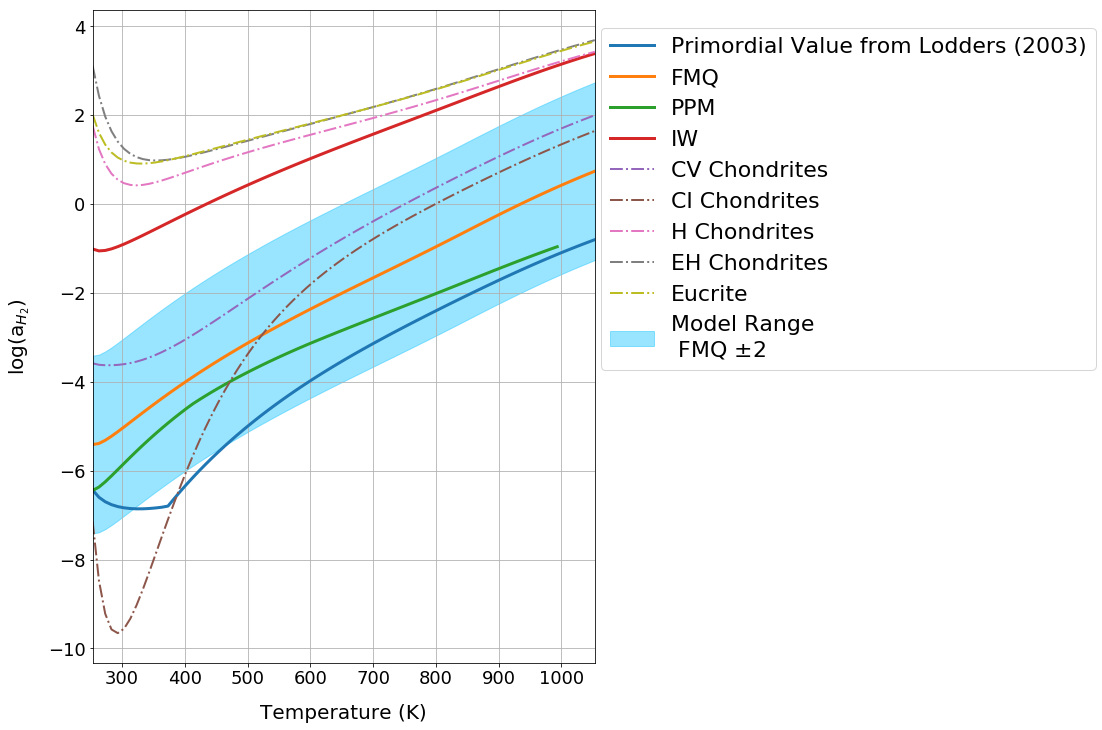

In [36]:
# ###Add upper limit assuming fH2 = 1500 bar
# #remove IW
# #look at old Shock/Shock & Schulte papers

# fig4 = plt.figure(4)
# fig4.set_figheight(12)
# fig4.set_figwidth(9)
# plt.clf()
# #plt.plot(T, fO2[0], 'b')
# plt.fill_between(C_to_K(T), fO2[2], fO2[0], alpha = 0.4, color = 'deepskyblue', label = 'Model Range \n FMQ $\pm 2$')
# plt.plot(T_Kelv, np.log10(fO2_prim), linewidth = 3, label = 'Primordial Value from Lodders (2003)')
# #plt.plot(T_Kelv, logK_FMQp, linewidth = 3, label = 'FMQ (1 bar)')
# #plt.plot(C_to_K(T_ppm), -logK_PPMp, linewidth = 3, label = 'PPM (1 bar)')
# plt.plot(C_to_K(T), fO2[1], linewidth = 3, label = 'FMQ (1500 bar)')
# plt.plot(C_to_K(T_PPM), fO2_PPM, linewidth = 3, label = 'PPM (1500 bar)')
# #plt.plot(C_to_K(T), fO2_IW[0:81], linewidth = 3, label = 'IW (1500 bar)')
# plt.plot(C_to_K(T), fO2_CV, '-.', markevery=10, linewidth = 2, label = 'CV Chondrites')
# plt.plot(C_to_K(T), fO2_CI, '-.', markevery=10, linewidth = 2, label = 'CI Chondrites')
# plt.plot(C_to_K(T), fO2_H, '-.', markevery=10, linewidth = 2, label = 'H Chondrites')
# plt.plot(C_to_K(T), fO2_EH, '-.', markevery=10, linewidth = 2, label = 'EH Chondrites')
# plt.plot(C_to_K(T), fO2_Euc, '-.', markevery=10, linewidth = 2, label = 'Eucrite')
# #plt.plot(T, fO2[2], 'b')
# #plt.xlabel('Temperature ($^\circ C$)')
# plt.xlabel('Temperature (K)')
# plt.ylabel(r'log(f$_{O_2}$)')
# plt.xlim(253, 1053)
# #plt.ylim(-2,16)
# #plt.text(300,0.5,'FMQ', size = 20, rotation = 10)
# #plt.text(270,2.5,'FMQ + 2', size = 20, rotation = 10)
# #plt.text(300,-1.4,'FMQ - 2', size = 20, rotation = 10)
# #plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
# plt.grid()
# plt.legend(bbox_to_anchor=(0.99,0.55), prop={'size': 22})
# plt.savefig('Speciation_Plots/logfO2_1500bar.png', bbox_inches = 'tight')
# plt.show()

fig5 = plt.figure(5)
fig5.set_figheight(12)
fig5.set_figwidth(9)
plt.clf()
#plt.plot(T, fO2[0], 'b')
plt.fill_between(C_to_K(T), (aH2[1]-2), (aH2[1]+2), alpha = 0.4, color = 'deepskyblue', label = 'Model Range\n FMQ $\pm 2$')
plt.plot(C_to_K(T), aH2_prim, linewidth = 3, label = 'Primordial Value from Lodders (2003)')
#plt.plot(C_to_K(T), aH2_FMQp, linewidth = 3, label = 'FMQ (1 bar)')
#plt.plot(C_to_K(T_ppm), aH2_PPMp, linewidth = 3, label = 'PPM (1 bar)')
plt.plot(C_to_K(T), aH2[1], linewidth = 3, label = 'FMQ')
plt.plot(C_to_K(T_PPM), aH2_PPM, linewidth = 3, label = 'PPM')
plt.plot(C_to_K(T), aH2_IW, linewidth = 3, label = 'IW')
plt.plot(C_to_K(T), aH2_CV, '-.', markevery=10, linewidth = 2, label = 'CV Chondrites')
plt.plot(C_to_K(T), aH2_CI, '-.', markevery=10, linewidth = 2, label = 'CI Chondrites')
plt.plot(C_to_K(T), aH2_H, '-.', markevery=10, linewidth = 2, label = 'H Chondrites')
plt.plot(C_to_K(T), aH2_EH, '-.', markevery=10, linewidth = 2, label = 'EH Chondrites')
plt.plot(C_to_K(T), aH2_Euc, '-.', markevery=10, linewidth = 2, label = 'Eucrite')
#plt.plot(T, fO2[2], 'b')
plt.xlabel('Temperature (K)')
plt.ylabel(r'log(a$_{H_2}$)')
plt.xlim(253, 1053)
#plt.ylim(-2,16)
#plt.text(300,0.5,'FMQ', size = 20, rotation = 10)
#plt.text(270,2.5,'FMQ + 2', size = 20, rotation = 10)
#plt.text(300,-1.4,'FMQ - 2', size = 20, rotation = 10)
#plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
plt.grid()
plt.legend(bbox_to_anchor=(0.99,0.99), prop={'size': 22})
plt.savefig('Speciation_Plots/logaH2_1500bar.png', bbox_inches = 'tight')
plt.show()


In [37]:
# T_Kelv = T+273

# fig1 = plt.figure(1)
# fig1.set_figheight(12)
# fig1.set_figwidth(9)
# plt.clf()
# #plt.plot(T, fO2[0], 'b')
# # plt.fill_between(T, (aH2[1]-2), (aH2[1]+2), alpha = 0.4, color = 'deepskyblue', label = 'Model Range\n FMQ $\pm 2$')
# # plt.plot(T, aH2[1], linewidth = 3, label = 'FMQ')
# # plt.plot(T, aH2_PPM, linewidth = 3, label = 'PPM')
# # plt.plot(T, aH2_IW, linewidth = 3, label = 'IW')
# # plt.plot(T, aH2_CV, '-.', markevery=10, linewidth = 2, label = 'CV Chondrites')
# # plt.plot(T, aH2_CI, '-.', markevery=10, linewidth = 2, label = 'CI Chondrites')
# # plt.plot(T, aH2_H, '-.', markevery=10, linewidth = 2, label = 'H Chondrites')
# # plt.plot(T, aH2_EH, '-.', markevery=10, linewidth = 2, label = 'EH Chondrites')
# # plt.plot(T, aH2_Euc, '-.', markevery=10, linewidth = 2, label = 'Eucrite')
# #plt.plot(T, fO2[2], 'b')
# plt.plot(T_Kelv, fO2, label = 'Primordial Value from Lodders (2003)')
# plt.plot(T_Kelv, 10**logK_FMQp, label = 'FMQ')
# plt.plot(T_ppm+273, 10**(-logK_PPMp), label = 'PPM')
# plt.xlabel('Temperature (K)')
# plt.ylabel(r'log(f$_{O_2}$)')
# plt.yscale('log')
# #plt.xlim(0, 500)
# #plt.ylim(-2,16)
# #plt.text(300,0.5,'FMQ', size = 20, rotation = 10)
# #plt.text(270,2.5,'FMQ + 2', size = 20, rotation = 10)
# #plt.text(300,-1.4,'FMQ - 2', size = 20, rotation = 10)
# #plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
# plt.grid()
# plt.legend(bbox_to_anchor=(0.99,0.99), prop={'size': 22})
# plt.savefig('Speciation_Plots/logfO2.png', bbox_inches = 'tight')
# plt.show()

In [38]:
#Change the pH
N, T, P, log_Kw = np.loadtxt('Europa_K/Kw_1500bar.txt', skiprows=8, unpack=True)
pH_neutral = -0.5*log_Kw #function of T
pH = np.zeros([7,len(pH_neutral)])
for i in range(-2,4):
    pH[i] = pH_neutral + i
    i = i+1

#oxidation state values: changing the temp range to what Chris suggested
#The FMQ buffer: 1.5Fe2SiO4 + H2O → Fe3O4 + 1.5SiO2 + H2
#logK = log(aH2) (all other activities are 1)
#N, T, P, logK_FMQ = np.loadtxt('Europa_K/FMQ_1500bar.txt', skiprows=10, unpack=True)
N, T, P, logK_FMQ = np.loadtxt('Europa_K/FMQ_1500bar.txt', skiprows=10, unpack=True)
aH2 = np.zeros([5,len(T)])
for i in range(-2,2):
    aH2[i] = logK_FMQ + i
    i = i+1
Sigma_C = np.logspace(-1,2,4) * 1e-3
Sigma_N = np.logspace(-1,2,4) * 1e-3

#Carbon, Nitrogen: 0.1mmol - 100mmol - don't go as high as 1 molar bc clathrates
#Pressure fixed 

In [39]:
T

array([1.00e-02, 1.00e+00, 2.00e+00, 3.00e+00, 4.00e+00, 5.00e+00,
       6.00e+00, 7.00e+00, 8.00e+00, 9.00e+00, 1.00e+01, 1.10e+01,
       1.20e+01, 1.30e+01, 1.40e+01, 1.50e+01, 1.60e+01, 1.70e+01,
       1.80e+01, 1.90e+01, 2.00e+01, 2.10e+01, 2.20e+01, 2.30e+01,
       2.40e+01, 2.50e+01, 2.60e+01, 2.70e+01, 2.80e+01, 2.90e+01,
       3.00e+01, 3.10e+01, 3.20e+01, 3.30e+01, 3.40e+01, 3.50e+01,
       3.60e+01, 3.70e+01, 3.80e+01, 3.90e+01, 4.00e+01, 4.10e+01,
       4.20e+01, 4.30e+01, 4.40e+01, 4.50e+01, 4.60e+01, 4.70e+01,
       4.80e+01, 4.90e+01, 5.00e+01, 5.10e+01, 5.20e+01, 5.30e+01,
       5.40e+01, 5.50e+01, 5.60e+01, 5.70e+01, 5.80e+01, 5.90e+01,
       6.00e+01, 6.10e+01, 6.20e+01, 6.30e+01, 6.40e+01, 6.50e+01,
       6.60e+01, 6.70e+01, 6.80e+01, 6.90e+01, 7.00e+01, 7.10e+01,
       7.20e+01, 7.30e+01, 7.40e+01, 7.50e+01, 7.60e+01, 7.70e+01,
       7.80e+01, 7.90e+01, 8.00e+01, 8.10e+01, 8.20e+01, 8.30e+01,
       8.40e+01, 8.50e+01, 8.60e+01, 8.70e+01, 8.80e+01, 8.90e

In [40]:


#logK values for speciation reactions:
#1 : CH4 + 2H2O → CO2 + 4H2
#K1 = [CO2](aH2)^4 / [CH4]
N, T, P, K_CO2 = np.loadtxt('Europa_K/Carbon/CO2.txt', skiprows=9, unpack=True)

#2: CH4 +3H2O → HCO3 +H +4H2
#K2 = [HCO3](aH+)(aH2)^4 / [CH4]
N, T, P, K_HCO3 = np.loadtxt('Europa_K/Carbon/HCO3.txt', skiprows=10, unpack=True)

#3: CH4 + 3H2O → CO3− + 2H+ +4H2
#K3 = [CO3-2](aH+)^2(aH2)^4 / [CH4]
N, T, P, K_CO3 = np.loadtxt('Europa_K/Carbon/CO3-2.txt', skiprows=10, unpack=True)

#4: CH4 + H2O -> CO + 3H2
#K4 = [CO](aH2)^3 / [CH4]
N, T, P, K_CO = np.loadtxt('Europa_K/Carbon/CO.txt', skiprows=9, unpack=True)

#5: CH4 + 2H2O -> HCOOH + 3H2
#K5 = [HCOOH](aH2)^3 / [CH4]
N, T, P, K_HCOOH = np.loadtxt('Europa_K/Carbon/HCOOH.txt', skiprows=9, unpack=True)

#6: CH4 + 2H2O -> HCOO- + H+ + 3H2
#K6 = [HCOO-](aH+)(aH2)^3 / [CH4]
N, T, P, K_HCOO = np.loadtxt('Europa_K/Carbon/HCOO-.txt', skiprows=10, unpack=True)

#7: CH4 + 3H2O -> H2CO3 + 4H2
#K7 = [H2CO3](aH2)^4 / [CH4]
N, T, P, K_H2CO3 = np.loadtxt('Europa_K/Carbon/H2CO3.txt', skiprows=9, unpack=True)

#8: 2CH4 -> C2H6 + H2
#K8 = [C2H6](aH2)/[CH4]^2
N, T, P, K_C2H6 = np.loadtxt('Europa_K/Carbon/C2H6.txt', skiprows=8, unpack=True)

#9: 3CH4 -> C3H8 + 2H2
#K9 = [C3H8](aH2)^2 / [CH4]^3
N, T, P, K_C3H8 = np.loadtxt('Europa_K/Carbon/C3H8.txt', skiprows=8, unpack=True)

#10: 4CH4 -> C4H10 + 3H2
#K10 = [C4H10](aH2)^3 / [CH4]^4
N, T, P, K_C4H10 = np.loadtxt('Europa_K/Carbon/C4H10.txt', skiprows=8, unpack=True)

In [55]:
Sigma_C

array([0.0001, 0.001 , 0.01  , 0.1   ])

In [49]:
#We have:
#SigmaC = CH4 + CO2 +  HCO3- + CO3-2 + CO + HCOOH + HCOO- + H2CO3 + 2C2H6 + 3C3H8 + 4C4H10
#Which yields the polynomial:
#A[CH4]^4 + B[CH4]^3 + C[CH4]^2 + D[CH4] + E

#Now let's calculate the coefficients:
#Varying pH and aH2:
#E = -10.04 #total C, mol/KgH2O, from Lodders (2003) and Alexander (2019)
E = -Sigma_C
A = np.zeros([len(aH2),len(T)])
B = np.zeros([len(aH2),len(T)])
C = np.zeros([len(aH2),len(T)])

for i in range(0,len(aH2)):
    A[i] = 4*(10**K_C4H10)/(10**aH2[i])
    B[i] = 3*(10**K_C3H8)/(10**aH2[i])
    C[i] = 2*(10**K_C2H6)/(10**aH2[i])

D = np.zeros([len(aH2),len(pH),len(T)])
for i in range(0, len(aH2)):
    for j in range(0, len(pH)):
        D[i,j] = 1 + (10**K_CO2)/((10**aH2[i])**4) + (10**K_HCO3)/((10**-pH[j])*(10**aH2[i])**4) + (10**K_CO3)/(((10**-pH[j])**2)*(10**aH2[i])**4) + (10**K_CO)/((10**aH2[i])**3) + (10**K_HCOOH)/((10**aH2[i])**3) + (10**K_HCOO)/((10**-pH[j])*(10**aH2[i])**3) + (10**K_H2CO3)/((10**aH2[i])**4) 

#Solve the polynomial for [CH4]:
CH4 = np.zeros([len(aH2),len(pH),len(E),len(T)])
for i in range(0, len(aH2)):
    for j in range(0, len(pH)):
        for k in range(0, len(E)):
            for m in range(0, len(T)):
                p = np.array([A[i,m],B[i,m],C[i,m],D[i,j,m],E[k]])
                r = np.roots(p)
                #pick the correct root:
                real_r = r[np.isreal(r)]
                CH4[i,j,k,m] = real_r[1]

#Now get the other concentrations:
CO2 = np.zeros([len(aH2), len(pH), len(E), len(T)])
HCO3 = np.zeros([len(aH2), len(pH), len(E), len(T)])
CO3 = np.zeros([len(aH2), len(pH), len(E), len(T)])
CO = np.zeros([len(aH2), len(pH), len(E), len(T)])
HCOOH = np.zeros([len(aH2), len(pH), len(E), len(T)])
HCOO = np.zeros([len(aH2), len(pH), len(E), len(T)])
H2CO3 = np.zeros([len(aH2), len(pH), len(E), len(T)])
C2H6 = np.zeros([len(aH2), len(pH), len(E), len(T)])
C3H8 = np.zeros([len(aH2), len(pH), len(E), len(T)])
C4H10 = np.zeros([len(aH2), len(pH), len(E), len(T)])

for i in range(0, len(aH2)):
    for j in range(0, len(pH)):
        for k in range(0, len(E)):
            CO2[i,j,k] = CH4[i,j,k]*(10**K_CO2)/((10**aH2[i])**4)
            HCO3[i,j,k] = CH4[i,j,k]*(10**K_HCO3)/((10**-pH[j])*(10**aH2[i])**4)
            CO3[i,j,k] = CH4[i,j,k]*(10**K_CO3)/(((10**-pH[j])**2)*(10**aH2[i])**4)
            CO[i,j,k] = CH4[i,j,k]*(10**K_CO)/((10**aH2[i])**3)
            HCOOH[i,j,k] = CH4[i,j,k]*(10**K_HCOOH)/((10**aH2[i])**3)
            HCOO[i,j,k] = CH4[i,j,k]*(10**K_HCOO)/((10**-pH[j])*(10**aH2[i])**3)
            H2CO3[i,j,k] = CH4[i,j,k]*(10**K_H2CO3)/((10**aH2[i])**4)
            C2H6[i,j,k] = (CH4[i,j,k]**2)*(10**K_C2H6)/(10**aH2[i])
            C3H8[i,j,k] = (CH4[i,j,k]**3)*(10**K_C3H8)/(10**aH2[i])
            C4H10[i,j,k] = (CH4[i,j,k]**4)*(10**K_C2H6)/(10**aH2[i])
    
#mole fractions - all WRT CH4 - FMQ
# X_CO2 = np.zeros([3,len(T)])
# X_CH4 = np.zeros([3,len(T)])
# X_CO3 = np.zeros([3,len(T)])
# X_HCO3 = np.zeros([3,len(T)]) 
# CO2 = np.zeros([3,len(T)])
# HCO3 = np.zeros([3,len(T)])
# CO3 = np.zeros([3,len(T)]) 
# for i in range(0, 3):
#     X_CO2[i] = (10**(10**K_CO2))/((10**(10**aH2[1]))**4)
#     X_HCO3[i] = (10**10**K_HCO3)/((10**-pH[i])*((10**(10**aH2[1]))**4))
#     X_CO3[i] = (10**10**K_CO3)/(((10**-pH[i])**2)*((10**(10**aH2[1]))**4))
#     X_CH4[i] = 1/(1 + X_CO2[i] + X_HCO3[i] + X_CO3[i])
#     CO2[i,:] = X_CO2[i,:]*X_CH4[i,:]
#     HCO3[i,:] = X_HCO3[i,:]*X_CH4[i,:]
#     CO3[i,:] = X_CO3[i,:]*X_CH4[i,:]

/Users/cray/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


In [50]:
CH4

array([[[[1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
          2.29633894e-06, 2.24026439e-06, 2.18589314e-06],
         [1.00000000e-03, 1.00000000e-03, 1.00000000e-03, ...,
          2.29633894e-05, 2.24026439e-05, 2.18589314e-05],
         [1.00000000e-02, 1.00000000e-02, 1.00000000e-02, ...,
          2.29633893e-04, 2.24026439e-04, 2.18589314e-04],
         [9.99999999e-02, 9.99999999e-02, 9.99999998e-02, ...,
          2.29633890e-03, 2.24026435e-03, 2.18589311e-03]],

        [[1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
          2.29612735e-06, 2.24006422e-06, 2.18570375e-06],
         [1.00000000e-03, 1.00000000e-03, 1.00000000e-03, ...,
          2.29612735e-05, 2.24006422e-05, 2.18570375e-05],
         [1.00000000e-02, 1.00000000e-02, 1.00000000e-02, ...,
          2.29612735e-04, 2.24006422e-04, 2.18570375e-04],
         [9.99999999e-02, 9.99999999e-02, 9.99999998e-02, ...,
          2.29612731e-03, 2.24006418e-03, 2.18570372e-03]],

        [[1.00000000

In [48]:
np.log10(C2H6)

array([[[[-16.182709  , -16.145293  , -16.107903  , ..., -15.05482102,
          -15.07823745, -15.10155715],
         [-14.182709  , -14.145293  , -14.107903  , ..., -13.05482102,
          -13.07823745, -13.10155715],
         [-12.182709  , -12.145293  , -12.107903  , ..., -11.05482102,
          -11.07823745, -11.10155715],
         [-10.182709  , -10.145293  , -10.107903  , ...,  -9.05482104,
           -9.07823746,  -9.10155716]],

        [[-16.182709  , -16.145293  , -16.107903  , ..., -15.05490106,
          -15.07831506, -15.10163241],
         [-14.182709  , -14.145293  , -14.107903  , ..., -13.05490106,
          -13.07831506, -13.10163241],
         [-12.182709  , -12.145293  , -12.107903  , ..., -11.05490106,
          -11.07831506, -11.10163241],
         [-10.182709  , -10.145293  , -10.107903  , ...,  -9.05490107,
           -9.07831508,  -9.10163242]],

        [[-16.182709  , -16.145293  , -16.107903  , ..., -15.05570105,
          -15.07909085, -15.10238468],
      

In [51]:
#Lump all carbon species into a dictionary for the purposes of sorting
carbon_species = {'CH4':CH4, 'C2H6':C2H6, 'C3H8':C3H8, 'C4H10':C4H10, 'CO':CO, 'CO2':CO2, 'HCOOH':HCOOH, 'HCOO':HCOO, 'H2CO3':H2CO3, 'HCO3':HCO3, 'CO3':CO3}

#Write species with concentrations > 1 molar for all conditions considered to a list
major_species = []
log_major_species = []
for item in carbon_species:
    species = carbon_species[item]
    for i in range (0,len(species)):
        if item in major_species:
            break
        else:
            for j in range (0,len(species[i])):
                if item in major_species:
                    break
                else:
                    for k in range (0,len(species[i,j])):
                        if item in major_species:
                            break
                        else:
                            for m in range (0,len(species[i,j,k])):
                                if species[i,j,k,m]>=1:
                                    major_species.append(item)
                                    break
    for i in range (0,len(species)):
        if item in log_major_species:
            break
        else:
            for j in range (0,len(species[i])):
                if item in log_major_species:
                    break
                else:
                    for k in range (0,len(species[i,j])):
                        if item in major_species:
                            break
                        else:
                            for m in range (0,len(species[i,j,k])):
                                if species[i,j,k,m]>=1e-1:
                                    major_species.append(item)
                                    break
                    
#Assign all species a color and a label for plotting
species = ['CH4', 'C2H6', 'C3H8', 'C4H10', 'CO', 'CO2', 'HCOOH', 'HCOO', 'H2CO3', 'HCO3', 'CO3']
color_sequence = ['darkorange', 'tomato', 'crimson', 'fuchsia', 'orchid', 'blueviolet', 'royalblue', 'mediumblue', 'darkcyan', 'darkturquoise', 'mediumspringgreen']
labels = ['CH$_4$', 'C$_2$H$_6$', 'C$_3$H$_8$', 'C$_4$H$_{10}$', 'CO', 'CO$_2$', 'HCOOH', 'HCOO$^{-}$', 'H$_2$CO$_3$', 'HCO$_3^-$', 'CO$_3^{-2}$']

for i in range(0,len(species)):
    carbon_species["%s_c" % species[i]] = color_sequence[i]
    carbon_species["%s_l" % species[i]] = labels[i]

In [52]:
CH4

array([[[[1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
          2.29633894e-06, 2.24026439e-06, 2.18589314e-06],
         [1.00000000e-03, 1.00000000e-03, 1.00000000e-03, ...,
          2.29633894e-05, 2.24026439e-05, 2.18589314e-05],
         [1.00000000e-02, 1.00000000e-02, 1.00000000e-02, ...,
          2.29633893e-04, 2.24026439e-04, 2.18589314e-04],
         [9.99999999e-02, 9.99999999e-02, 9.99999998e-02, ...,
          2.29633890e-03, 2.24026435e-03, 2.18589311e-03]],

        [[1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
          2.29612735e-06, 2.24006422e-06, 2.18570375e-06],
         [1.00000000e-03, 1.00000000e-03, 1.00000000e-03, ...,
          2.29612735e-05, 2.24006422e-05, 2.18570375e-05],
         [1.00000000e-02, 1.00000000e-02, 1.00000000e-02, ...,
          2.29612735e-04, 2.24006422e-04, 2.18570375e-04],
         [9.99999999e-02, 9.99999999e-02, 9.99999998e-02, ...,
          2.29612731e-03, 2.24006418e-03, 2.18570372e-03]],

        [[1.00000000

ValueError: x and y must have same first dimension, but have shapes (1,) and (4, 501)

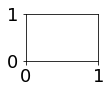

In [69]:
aH2_lim = (-8, 0)
aH2_ticks = (1e-6, 1e-4, 1e-2)
aH2_labels = ('-6', '-4', '-2')

pH_lim = (0, 11)
pH_ticks = (3, 6, 9)
pH_labels = ('3', '6', '9')

C_lim = (0.1, 100)
C_ticks = (1, 10, 100)
C_labels = ('0', '1', '2')

T_lim = (0, 500)
T_ticks = (100, 400)
T_labels = ('100', '400')


labels = ['aH$_2$', 'pH', '$\Sigma$C', 'T']
#First row
fig = plt.figure(1)

ax = plt.subplot(4,4,1)
a = plt.plot(aH2[0,0], CO3[0,0], 'k.', markersize = 4.0)
#b = plt.l(CO2[1,0], CO3[1,0], 'g.', markersize = 5.0)
#c = plt.loglog(CO2[2,0], CO3[2,0], 'b.', markersize = 5.0)
plt.xlabel(labels[0])
plt.ylabel(labels[-1])
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.yticks(CO3_ticks, CO3_labels)
plt.ylim(CO3_lim)
plt.xticks(CO2_ticks, CO2_labels)
plt.xlim(CO2_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

ax = plt.subplot(4,4,2)
plt.loglog(CH4[0,0], CO3[0,0], 'k.', markersize = 4.0)
plt.loglog(CH4[1,0], CO3[1,0], 'g.', markersize = 5.0)
plt.loglog(CH4[2,0], CO3[2,0], 'b.', markersize = 5.0)
plt.xlabel(labels[1])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.xticks(CH4_ticks, CH4_labels)
plt.xlim(CH4_lim)

ax = plt.subplot(4,4,3)
plt.loglog(H2CO3[0,0], CO3[0,0], 'k.', markersize = 4.0)
plt.loglog(H2CO3[1,0], CO3[1,0], 'g.', markersize = 5.0)
plt.loglog(H2CO3[2,0], CO3[2,0], 'b.', markersize = 5.0)
plt.xlabel(labels[2])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.xticks(H2CO3_ticks, H2CO3_labels)
plt.xlim(H2CO3_lim)

ax = plt.subplot(4,4,4)
plt.loglog(HCO3[0,0], CO3[0,0], 'k.', markersize = 4.0)
plt.loglog(HCO3[1,0], CO3[1,0], 'g.', markersize = 5.0)
plt.loglog(HCO3[2,0], CO3[2,0], 'b.', markersize = 5.0)
plt.xlabel(labels[3])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.xlim(HCO3_lim)
plt.xticks(HCO3_ticks, HCO3_labels)

# #Second Row
ax = plt.subplot(4,4,5)
a = plt.loglog(CO2[0,0], HCO3[0,0], 'k.', markersize = 4.0)
b = plt.loglog(CO2[1,0], HCO3[1,0], 'g.', markersize = 5.0)
c = plt.loglog(CO2[2,0], HCO3[2,0], 'b.', markersize = 5.0)
plt.ylabel(labels[-2])
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.setp(ax.get_xticklabels(), visible=False)
plt.yticks(HCO3_ticks, HCO3_labels)
plt.ylim(HCO3_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

ax = plt.subplot(4,4,6)
plt.loglog(CH4[0,0], HCO3[0,0], 'k.', markersize = 4.0)
plt.loglog(CH4[1,0], HCO3[1,0], 'g.', markersize = 5.0)
plt.loglog(CH4[2,0], HCO3[2,0], 'b.', markersize = 5.0)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)

ax = plt.subplot(4,4,7)
plt.loglog(H2CO3[0,0], HCO3[0,0], 'k.', markersize = 4.0)
plt.loglog(H2CO3[1,0], HCO3[1,0], 'g.', markersize = 5.0)
plt.loglog(H2CO3[2,0], HCO3[2,0], 'b.', markersize = 5.0)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)


# Third Row
ax = plt.subplot(4,4,8)
a = plt.loglog(CO2[0,0], H2CO3[0,0], 'k.', markersize = 4.0)
b = plt.loglog(CO2[1,0], H2CO3[1,0], 'g.', markersize = 5.0)
c = plt.loglog(CO2[2,0], H2CO3[2,0], 'b.', markersize = 5.0)
plt.ylabel(labels[-3])
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.setp(ax.get_xticklabels(), visible=False)
plt.yticks(H2CO3_ticks, H2CO3_labels)
plt.ylim(H2CO3_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

ax = plt.subplot(4,4,9)
plt.loglog(CH4[0,0], H2CO3[0,0], 'k.', markersize = 4.0)
plt.loglog(CH4[1,0], H2CO3[1,0], 'g.', markersize = 5.0)
plt.loglog(CH4[2,0], H2CO3[2,0], 'b.', markersize = 5.0)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)


# Fourth Row
ax = plt.subplot(4,4,10)
plt.hist(CO2[0,0], bins = 50, normed = True, range = CO2_lim, color = 'k')
plt.hist(CO2[1,0], bins = 50, normed = True, range = CO2_lim, color = 'g')
plt.hist(CO2[2,0], bins = 50, normed = True, range = CO2_lim, color = 'b')
plt.ylabel(labels[-5])
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)

#Adjust spacing in subloglogs
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.00, hspace=0.00)

left  = 0.125  # the left side xof the subloglogs of the figure
right = 0.9    # the right side of the subloglogs of the figure
bottom = 0.1   # the bottom of the subloglogs of the figure
top = 0.9      # the top of the subloglogs of the figure
wspace = 0.2   # the amount of width reserved for blank space between subloglogs
hspace = 0.5   # the amount of height reserved for white space between subloglogs

plt.show()

ValueError: x and y must have same first dimension, but have shapes (501,) and (4, 501)

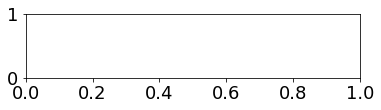

In [59]:
#Plot only species in major species list:
#1. Individual plots:
fig2 = plt.figure(2)
ax = plt.subplot(311) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,0], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 5, r'pH$_{neutral}$',size = 18)

plt.legend(bbox_to_anchor=(1,1), prop={'size': 14})
plt.title(r'$a$H$_2$ = FMQ-2')

ax = plt.subplot(312) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,1], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 5, r'pH$_{neutral} + 2$',size = 18)

ax = plt.subplot(313) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,2], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 5, r'pH$_{neutral}$ + 4',size = 18)


plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Carbon/FMQ-2_1500bar.png', bbox_inches = 'tight')



fig3 = plt.figure(3)
ax = plt.subplot(311) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,0], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
#plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(90, 5, r'pH$_{neutral}$',size = 18)

plt.legend(bbox_to_anchor=(1,1), prop={'size': 14})
plt.title(r'$a$H$_2$ = FMQ')

ax = plt.subplot(312) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,1], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(90, 5, r'pH$_{neutral} + 2$',size = 18)

ax = plt.subplot(313) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,2], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
#plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,10.3)
#plt.setp(ax.get_xticklabels(), visible=False)
plt.xlabel('Temperature ($\degree$C)')
plt.grid()
plt.text(90, 5, r'pH$_{neutral}$ + 4',size = 18)


plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Carbon/FMQ_1500bar.png', bbox_inches = 'tight')



fig4 = plt.figure(4)
ax = plt.subplot(311) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,0], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 5, r'pH$_{neutral}$',size = 18)

plt.legend(bbox_to_anchor=(1,1), prop={'size': 14})
plt.title(r'$a$H$_2$ = FMQ+2')

ax = plt.subplot(312) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,1], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 5, r'pH$_{neutral} + 2$',size = 18)

ax = plt.subplot(313) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,2], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 5, r'pH$_{neutral}$ + 4',size = 18)


plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Carbon/FMQ+2_1500bar.png', bbox_inches = 'tight')

In [61]:
CH4

array([[[[-1.00000000e-01, -1.00000000e-01, -1.00000000e-01, ...,
          -2.29633898e-03, -2.24026443e-03, -2.18589317e-03],
         [-1.00000001e+00, -1.00000001e+00, -1.00000002e+00, ...,
          -2.29633934e-02, -2.24026477e-02, -2.18589349e-02],
         [-1.00000013e+01, -1.00000014e+01, -1.00000016e+01, ...,
          -2.29634299e-01, -2.24026813e-01, -2.18589660e-01],
         [-1.00000131e+02, -1.00000143e+02, -1.00000156e+02, ...,
          -2.29637941e+00, -2.24030180e+00, -2.18592774e+00]],

        [[-1.00000000e-01, -1.00000000e-01, -1.00000000e-01, ...,
          -2.29612739e-03, -2.24006426e-03, -2.18570378e-03],
         [-1.00000001e+00, -1.00000001e+00, -1.00000002e+00, ...,
          -2.29612776e-02, -2.24006460e-02, -2.18570410e-02],
         [-1.00000013e+01, -1.00000014e+01, -1.00000016e+01, ...,
          -2.29613140e-01, -2.24006796e-01, -2.18570721e-01],
         [-1.00000131e+02, -1.00000143e+02, -1.00000156e+02, ...,
          -2.29616782e+00, -2.240101

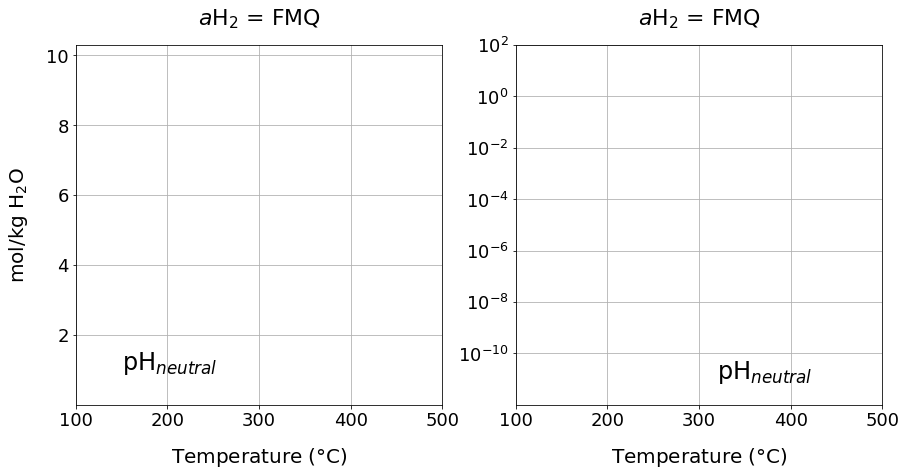

In [53]:
fig1 = plt.figure(1)
fig1.set_figheight(10)
fig1.set_figwidth(14)

ax = plt.subplot(121) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,0], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlabel('Temperature ($\degree$C)')
plt.xlim(100, 500)
plt.ylim(0,10.3)
plt.yticks([2,4,6,8,10])
#plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(150, 1, r'pH$_{neutral}$',size = 24)

plt.legend(bbox_to_anchor=(0.5,0.5), prop={'size': 18})
plt.title(r'$a$H$_2$ = FMQ')

ax = plt.subplot(122)
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,0], label = r'%s' %carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
#plt.ylabel('mol/kg H$_2$O')
plt.xlabel('Temperature ($\degree$C)')
plt.xlim(100, 500)
ax.set_yscale('log')
plt.ylim(1e-12,1e2)
plt.yticks([1e-10,1e-8,1e-6, 1e-4, 1e-2, 1e0, 1e2])
#plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(320, 1e-11, r'pH$_{neutral}$',size = 24)
plt.legend(bbox_to_anchor=(1,1), prop={'size': 18})
plt.title(r'$a$H$_2$ = FMQ')


plt.subplots_adjust(left = 1.0, bottom=3.5, right=1.8, top=4,
                 wspace=0.2, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Carbon/Temp_dep.png', bbox_inches = 'tight')

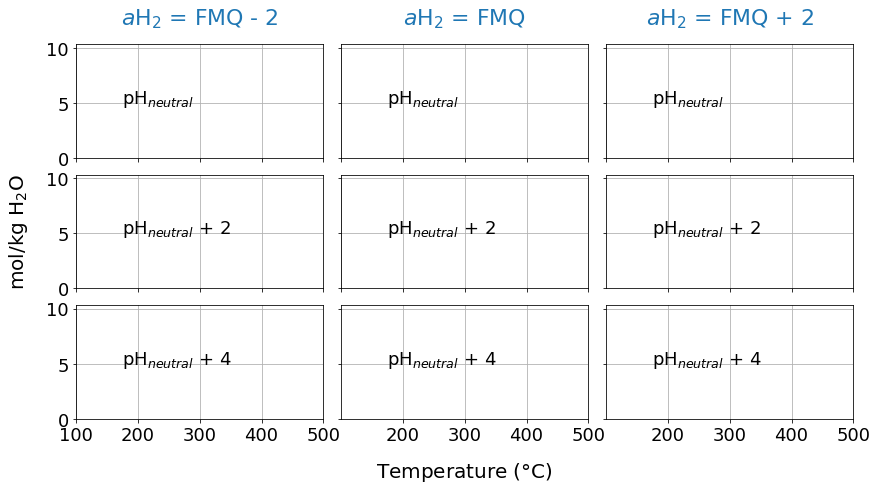

In [54]:
#Plot only species in major species list:
#1. All subplots together:
fig5 = plt.figure(5)
ax = plt.subplot(331) 
for species_name in major_species:
    if species_name != 'C4H10': #ignoring butane for now because something's weird with it...
        plt.plot(T,carbon_species[species_name][0,0], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
#plt.ylabel('mol/kg H$_2$O')
plt.xlim(100, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 5, r'pH$_{neutral}$',size = 18)
plt.title(r'$a$H$_2$ = FMQ - 2', color = '#1f77b4')

ax = plt.subplot(332) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,0], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(175, 5, r'pH$_{neutral} $',size = 18)
plt.title(r'$a$H$_2$ = FMQ', color = '#1f77b4')

ax = plt.subplot(333) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,0], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(175, 5, r'pH$_{neutral} $',size = 18)
plt.legend(bbox_to_anchor=(1,1), prop={'size': 14})
plt.title(r'$a$H$_2$ = FMQ + 2', color = '#1f77b4')

ax = plt.subplot(334) 
for species_name in major_species:
    if species_name != 'C4H10':    
        plt.plot(T,carbon_species[species_name][0,1], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(100, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 5, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(335) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,1], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(175, 5, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(336) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,1], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(0,10.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xticks([200,300,400,500])
plt.grid()
plt.text(175, 5, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(337) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,2], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
#plt.ylabel('mol/kg H$_2$O')
plt.xlim(100, 500)
plt.ylim(0,10.3)
plt.grid()
plt.text(175, 5, r'pH$_{neutral}$ + 4',size = 18)
#plt.xlabel('Temperature ($\degree$C)')

ax = plt.subplot(338) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,2], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(0,10.3)
plt.grid()
plt.xticks([200,300,400,500])
plt.text(175, 5, r'pH$_{neutral}$ + 4',size = 18)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel('Temperature ($\degree$C)')

ax = plt.subplot(339) 
for species_name in major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,2], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(0,10.3)
plt.grid()
plt.text(175, 5, r'pH$_{neutral}$ + 4',size = 18)
plt.setp(ax.get_yticklabels(), visible=False)
#plt.xlabel('Temperature ($\degree$C)')
plt.xticks([200,300,400,500])
plt.subplots_adjust(left = 1.0, bottom=0.7, right=2.8, top=2,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Carbon/all_1500bar.png', bbox_inches = 'tight')




In [110]:
np.amin(np.log10(CH4))

-13.653286543202853

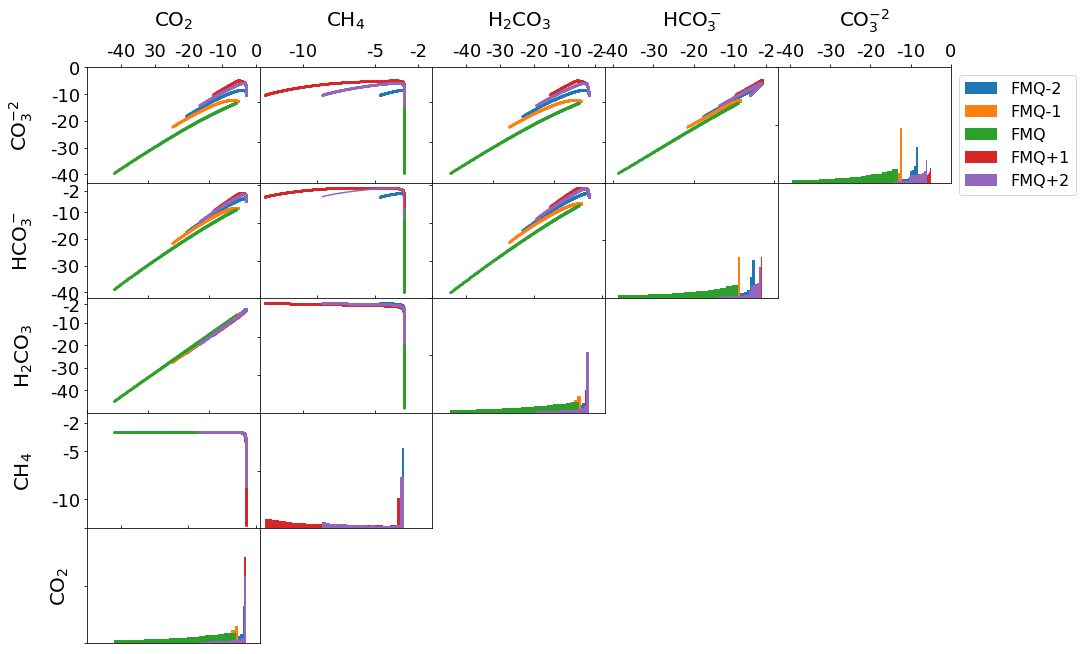

In [191]:
CO3_lim = (1e-43, 1e0)
CO3_ticks = (1e-40, 1e-30, 1e-20, 1e-10, 1e0)
CO3_labels = ('-40','-30', '-20', '-10', '0')

HCO3_lim = (1e-42, 1e1)
HCO3_ticks = (1e-40, 1e-30, 1e-20, 1e-10, 1e-2)
HCO3_labels = ('-40', '-30', '-20', '-10', '-2')

H2CO3_lim = (1e-50, 1e1)
H2CO3_ticks = (1e-40, 1e-30, 1e-20, 1e-10, 1e-2)
H2CO3_labels = ('-40', '-30', '-20', '-10', '-2')

CH4_lim = (1e-13, 1e-1)
CH4_ticks = (1e-10, 1e-5, 1e-2)
CH4_labels = ('-10', '-5', '-2')

CO2_lim = (1e-50, 1e1)
CO2_ticks = (1e-40, 1e-30, 1e-20, 1e-10, 1e0)
CO2_labels = ('-40', '30', '-20', '-10', '0')

labels = ['CO$_2$', 'CH$_4$', 'H$_2$CO$_3$', 'HCO$_3^-$', 'CO$_3^{-2}$']
#First row
fig = plt.figure(1)

ax = plt.subplot(5,5,1)
plt.loglog(CO2[0,2,1], CO3[0,2,1], '.', markersize = 3.0)
plt.loglog(CO2[1,2,1], CO3[1,2,1], '.',  markersize = 3.0)
plt.loglog(CO2[2,2,1], CO3[2,2,1], '.',  markersize = 3.0)
plt.loglog(CO2[3,2,1], CO3[3,2,1], '.',  markersize = 3.0)
plt.loglog(CO2[4,2,1], CO3[4,2,1], '.',  markersize = 3.0)
plt.xlabel(labels[0])
plt.ylabel(labels[-1])
ax.xaxis.set_label_position('top')
plt.yticks(CO3_ticks, CO3_labels)
plt.ylim(CO3_lim)
plt.xticks(CO2_ticks, CO2_labels)
plt.xlim(CO2_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.xaxis.tick_top()

ax = plt.subplot(5,5,2)
plt.loglog(CH4[0,2,1], CO3[0,2,1], '.',  markersize = 3.0)
plt.loglog(CH4[1,2,1], CO3[1,2,1], '.',  markersize = 3.0)
plt.loglog(CH4[2,2,1], CO3[2,2,1], '.',  markersize = 3.0)
plt.loglog(CH4[3,2,1], CO3[3,2,1], '.',  markersize = 3.0)
plt.loglog(CH4[4,2,1], CO3[4,2,1], '.',  markersize = 3.0)
plt.xlabel(labels[1])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.xticks(CH4_ticks, CH4_labels)
plt.xlim(CH4_lim)
plt.ylim(CO3_lim)

ax = plt.subplot(5,5,3)
plt.loglog(H2CO3[0,2,1], CO3[0,2,1], '.',  markersize = 3.0)
plt.loglog(H2CO3[1,2,1], CO3[1,2,1], '.',  markersize = 3.0)
plt.loglog(H2CO3[2,2,1], CO3[2,2,1], '.',  markersize = 3.0)
plt.loglog(H2CO3[3,2,1], CO3[3,2,1], '.',  markersize = 3.0)
plt.loglog(H2CO3[4,2,1], CO3[4,2,1], '.',  markersize = 3.0)
plt.xlabel(labels[2])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(H2CO3_ticks, H2CO3_labels)
plt.xlim(H2CO3_lim)
plt.ylim(CO3_lim)

ax = plt.subplot(5,5,4)
plt.loglog(HCO3[0,2,1], CO3[0,2,1], '.',  markersize = 3.0)
plt.loglog(HCO3[1,2,1], CO3[1,2,1], '.',  markersize = 3.0)
plt.loglog(HCO3[2,2,1], CO3[2,2,1], '.',  markersize = 3.0)
plt.loglog(HCO3[3,2,1], CO3[3,2,1], '.',  markersize = 3.0)
plt.loglog(HCO3[4,2,1], CO3[4,2,1], '.',  markersize = 3.0)
plt.xlabel(labels[3])
plt.setp(ax.get_yticklabels(), visible=False)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xlim(HCO3_lim)
plt.ylim(CO3_lim)
plt.xticks(HCO3_ticks, HCO3_labels)


def weight(array):
    weight = np.ones_like(array)/float(len(array))
    return weight

ax = plt.subplot(5,5,5)
ax.xaxis.set_label_position('top')
ax.xaxis.set_tick_params(labeltop='on')
plt.hist(np.log10(CO3[0,2,1]), bins = 20, weights=weight(CO3[0,2,1]), label = 'FMQ-2')
plt.hist(np.log10(CO3[1,2,1]), bins = 20, weights=weight(CO3[1,2,1]), label = 'FMQ-1')
plt.hist(np.log10(CO3[2,2,1]), bins = 20, weights=weight(CO3[2,2,1]), label = 'FMQ')
plt.hist(np.log10(CO3[3,2,1]), bins = 20, weights=weight(CO3[3,2,1]), label = 'FMQ+1')
plt.hist(np.log10(CO3[4,2,1]), bins = 20, weights=weight(CO3[4,2,1]), label = 'FMQ+2')
plt.ylim(0,1)
#plt.xlim(CO3_lim)

plt.xlabel(labels[4])
plt.setp(ax.get_yticklabels(), visible=False)
plt.legend(bbox_to_anchor=(1,1), prop={'size': 16})
plt.ylim(0,1)
plt.xlim(np.log10(CO3_lim))
plt.xticks(np.log10(CO3_ticks), CO3_labels)
ax.xaxis.tick_top()

# #Second Row
ax = plt.subplot(5,5,6)
plt.loglog(CO2[0,2,1], HCO3[0,2,1], '.',  markersize = 3.0)
plt.loglog(CO2[1,2,1], HCO3[1,2,1], '.',  markersize = 3.0)
plt.loglog(CO2[2,2,1], HCO3[2,2,1], '.',  markersize = 3.0)
plt.loglog(CO2[3,2,1], HCO3[3,2,1], '.',  markersize = 3.0)
plt.loglog(CO2[4,2,1], HCO3[4,2,1], '.',  markersize = 3.0)
plt.ylabel(labels[-2])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), visible=False)
plt.yticks(HCO3_ticks, HCO3_labels)
plt.ylim(HCO3_lim)
plt.xlim(CO2_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

ax = plt.subplot(5,5,7)
plt.loglog(CH4[0,2,1], HCO3[0,2,1], '.',  markersize = 3.0)
plt.loglog(CH4[1,2,1], HCO3[1,2,1], '.',  markersize = 3.0)
plt.loglog(CH4[2,2,1], HCO3[2,2,1], '.',  markersize = 3.0)
plt.loglog(CH4[3,2,1], HCO3[3,2,1], '.',  markersize = 3.0)
plt.loglog(CH4[4,2,1], HCO3[4,2,1], markersize = 3.0)
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(CH4_lim)

ax = plt.subplot(5,5,8)
plt.loglog(H2CO3[0,2,1], HCO3[0,2,1], '.',  markersize = 3.0)
plt.loglog(H2CO3[1,2,1], HCO3[1,2,1], '.',  markersize = 3.0)
plt.loglog(H2CO3[2,2,1], HCO3[2,2,1], '.',  markersize = 3.0)
plt.loglog(H2CO3[3,2,1], HCO3[3,2,1], '.',  markersize = 3.0)
plt.loglog(H2CO3[4,2,1], HCO3[4,2,1], '.',  markersize = 3.0)
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(H2CO3_lim)

ax = plt.subplot(5,5,9)
plt.hist(np.log10(HCO3[0,2,1]), bins = 20, weights=weight(HCO3[0,2,1]),)
plt.hist(np.log10(HCO3[1,2,1]), bins = 20, weights=weight(HCO3[1,2,1]),)
plt.hist(np.log10(HCO3[2,2,1]), bins = 20, weights=weight(HCO3[2,2,1]),)
plt.hist(np.log10(HCO3[3,2,1]), bins = 20, weights=weight(HCO3[3,2,1]),)
plt.hist(np.log10(HCO3[4,2,1]), bins = 20, weights=weight(HCO3[4,2,1]),)
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.ylim(0,1)
plt.xlim(np.log10(HCO3_lim))

# Third Row
ax = plt.subplot(5,5,11)
plt.loglog(CO2[0,2,1], H2CO3[0,2,1], '.',  markersize = 3.0)
plt.loglog(CO2[1,2,1], H2CO3[1,2,1], '.',  markersize = 3.0)
plt.loglog(CO2[2,2,1], H2CO3[2,2,1], '.',  markersize = 3.0)
plt.loglog(CO2[3,2,1], H2CO3[3,2,1], '.',  markersize = 3.0)
plt.loglog(CO2[4,2,1], H2CO3[4,2,1], '.',  markersize = 3.0)
plt.ylabel(labels[-3])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), visible=False)
plt.yticks(H2CO3_ticks, H2CO3_labels)
plt.ylim(H2CO3_lim)
plt.xlim(CO2_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

ax = plt.subplot(5,5,12)
plt.loglog(CH4[0,0,1], H2CO3[0,0,1], '.',  markersize = 3.0)
plt.loglog(CH4[1,0,1], H2CO3[1,0,1], '.',  markersize = 3.0)
plt.loglog(CH4[2,0,1], H2CO3[2,0,1], '.',  markersize = 3.0)
plt.loglog(CH4[3,0,1], H2CO3[3,0,1], '.',  markersize = 3.0)
plt.loglog(CH4[4,0,1], H2CO3[4,0,1], '.',  markersize = 3.0)
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.xlim(CH4_lim)

ax = plt.subplot(5,5,13)
plt.hist(np.log10(H2CO3[0,0,1]), bins = 20, weights=weight(H2CO3[0,2,1]),)
plt.hist(np.log10(H2CO3[1,0,1]), bins = 20, weights=weight(H2CO3[1,2,1]),)
plt.hist(np.log10(H2CO3[2,0,1]), bins = 20, weights=weight(H2CO3[2,2,1]),)
plt.hist(np.log10(H2CO3[3,0,1]), bins = 20, weights=weight(H2CO3[3,2,1]),)
plt.hist(np.log10(H2CO3[4,0,1]), bins = 20, weights=weight(H2CO3[4,2,1]),)
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.ylim(0,1)
plt.xlim(np.log10(H2CO3_lim))

# Fourth Row
ax = plt.subplot(5,5,16)
plt.loglog(CO2[0,0,1], CH4[0,0,1], '.',  markersize = 3.0)
plt.loglog(CO2[1,0,1], CH4[1,0,1], '.',  markersize = 3.0)
plt.loglog(CO2[2,0,1], CH4[2,0,1], '.',  markersize = 3.0)
plt.loglog(CO2[3,0,1], CH4[3,0,1], '.',  markersize = 3.0)
plt.loglog(CO2[4,0,1], CH4[4,0,1], '.',  markersize = 3.0)
plt.ylabel(labels[-4])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), visible=False)
plt.yticks(CH4_ticks, CH4_labels)
plt.ylim(CH4_lim)
plt.xlim(CO2_lim)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

ax = plt.subplot(5,5,17)
plt.hist(np.log10(CH4[0,0,1]), bins = 20, weights=weight(CH4[0,2,1]),)
plt.hist(np.log10(CH4[1,0,1]), bins = 20, weights=weight(CH4[1,2,1]),)
plt.hist(np.log10(CH4[2,0,1]), bins = 20, weights=weight(CH4[2,2,1]),)
plt.hist(np.log10(CH4[3,0,1]), bins = 20, weights=weight(CH4[3,2,1]),)
plt.hist(np.log10(CH4[4,0,1]), bins = 20, weights=weight(CH4[4,2,1]),)
ax.xaxis.tick_top()
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.ylim(0,1)
plt.xlim(np.log10(CH4_lim))

#Fifth Row
ax = plt.subplot(5,5,21)
plt.hist(np.log10(CO2[0,0,1]), bins = 20, weights=weight(CO2[0,2,1]),)
plt.hist(np.log10(CO2[1,0,1]), bins = 20, weights=weight(CO2[1,2,1]),)
plt.hist(np.log10(CO2[2,0,1]), bins = 20, weights=weight(CO2[2,2,1]),)
plt.hist(np.log10(CO2[3,0,1]), bins = 20, weights=weight(CO2[3,2,1]),)
plt.hist(np.log10(CO2[4,0,1]), bins = 20, weights=weight(CO2[4,2,1]),)
ax.xaxis.tick_top()
plt.ylabel(labels[-5])
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.ylim(0,1)
plt.xlim(np.log10(CO2_lim))


#Adjust spacing in subloglogs
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.00, hspace=0.00)

left  = 0.125  # the left side xof the subloglogs of the figure
right = 0.9    # the right side of the subloglogs of the figure
bottom = 0.1   # the bottom of the subloglogs of the figure
top = 0.9      # the top of the subloglogs of the figure
wspace = 0.2   # the amount of width reserved for blank space between subloglogs
hspace = 0.5   # the amount of height reserved for white space between subloglogs

plt.savefig('Speciation_Plots/Carbon/Carbon_Pyramid.png', bbox_inches = 'tight')
#plt.show()

(0, 9)

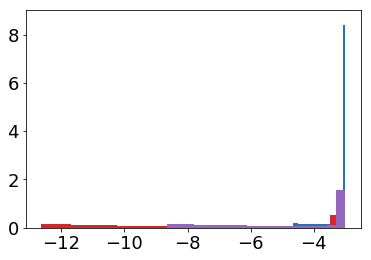

In [149]:
plt.hist(np.log10(CH4[0,0,1]), bins = 20, density = True)
plt.hist(np.log10(CH4[1,0,1]), bins = 20, density = True)
plt.hist(np.log10(CH4[2,0,1]), bins = 20, density = True)
plt.hist(np.log10(CH4[3,0,1]), bins = 20, density = True)
plt.hist(np.log10(CH4[4,0,1]), bins = 20, density = True)
plt.ylim(0,9)

In [133]:
np.amax(CO2)

0.09725211085812228

In [27]:
#Try another one looking at the parameter space:

# T_lim = (100, 500)
# T_ticks = (200, 300, 400)
# T_labels = ('200', '300', '400')

# aH2_lim = (-8, 1)
# aH2_ticks = (-7, -3, 0)

# pH_lim = (5, 12)
# pH_ticks = (7, 10)

# labels = ['T', 'aH$_2$', 'pH']

# def vol_ratio(a,b):
#     return a/b

# #First row
# fig = plt.figure(1)

# ax = plt.subplot(3,3,1)
# for i in len(pH)
#     plt.contour(T,pH[i],vol_ratio(CH4[]))
# plt.xlabel(labels[0])
# plt.ylabel(labels[-1])
# ax.xaxis.set_label_position('top')
# ax.xaxis.set_tick_params(labeltop='on')
# plt.yticks(pH_ticks)
# plt.ylim(pH_lim)
# plt.xticks(T_ticks)
# plt.xlim(T_lim)
# ax.yaxis.label.set_size(20)
# ax.xaxis.label.set_size(20)

# ax = plt.subplot(3,3,2)

# plt.xlabel(labels[1])
# plt.setp(ax.get_yticklabels(), visible=False)
# ax.xaxis.set_label_position('top')
# ax.xaxis.set_tick_params(labeltop='on')
# plt.xticks(aH2_ticks)
# plt.xlim(aH2_lim)

# ax = plt.subplot(3,3,3)

# plt.xlabel(labels[2])
# plt.setp(ax.get_yticklabels(), visible=False)
# ax.xaxis.set_label_position('top')
# ax.xaxis.set_tick_params(labeltop='on')
# plt.xticks(pH_ticks)
# plt.xlim(pH_lim)


# # #Second Row
# ax = plt.subplot(3,3,4)
# a = plt.loglog(CO2[0,0], HCO3[0,0], 'k.', markersize = 4.0)
# b = plt.loglog(CO2[1,0], HCO3[1,0], 'g.', markersize = 5.0)
# c = plt.loglog(CO2[2,0], HCO3[2,0], 'b.', markersize = 5.0)
# plt.ylabel(labels[-2])
# ax.xaxis.set_label_position('top')
# ax.xaxis.set_tick_params(labeltop='on')
# plt.setp(ax.get_xticklabels(), visible=False)
# plt.yticks(HCO3_ticks, HCO3_labels)
# plt.ylim(HCO3_lim)
# ax.yaxis.label.set_size(20)
# ax.xaxis.label.set_size(20)

# ax = plt.subplot(3,3,5)
# plt.loglog(CH4[0,0], HCO3[0,0], 'k.', markersize = 4.0)
# plt.loglog(CH4[1,0], HCO3[1,0], 'g.', markersize = 5.0)
# plt.loglog(CH4[2,0], HCO3[2,0], 'b.', markersize = 5.0)
# plt.setp(ax.get_yticklabels(), visible=False)
# plt.setp(ax.get_xticklabels(), visible=False)


# # Third Row

# ax = plt.subplot(3,3,7)
# plt.hist(H2CO3[0,0], bins = 50, normed = True, range = H2CO3_lim, color = 'k')
# plt.hist(H2CO3[1,0], bins = 50, normed = True, range = H2CO3_lim, color = 'g')
# plt.hist(H2CO3[2,0], bins = 50, normed = True, range = H2CO3_lim, color = 'b')
# plt.setp(ax.get_yticklabels(), visible=False)
# plt.setp(ax.get_xticklabels(), visible=False)


#Adjust spacing in subloglogs
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.00, hspace=0.00)

left  = 0.125  # the left side xof the subloglogs of the figure
right = 0.9    # the right side of the subloglogs of the figure
bottom = 0.1   # the bottom of the subloglogs of the figure
top = 0.9      # the top of the subloglogs of the figure
wspace = 0.2   # the amount of width reserved for blank space between subloglogs
hspace = 0.5   # the amount of height reserved for white space between subloglogs

plt.show()

KeyError: 'NH3'

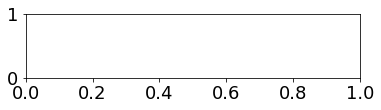

In [113]:
fig6 = plt.figure(6)
ax = plt.subplot(311) 
for species_name in log_major_species:
     if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,0], label = r'%s' %carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
ax.set_yscale('log')
plt.ylim(1e-12,1e2)
#plt.yticks([1e-10,1e-10,1e1])
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(300, 5e-11, r'pH$_{neutral}$',size = 18)
plt.legend(bbox_to_anchor=(1,1), prop={'size': 14})
plt.title(r'$a$H$_2$ = FMQ')

ax = plt.subplot(312) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,1], label = r'%s' %carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
ax.set_yscale('log')
plt.ylim(1e-12,1e2)
#plt.yticks([1e-20,1e-10,1e1])
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(300, 5e-11, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(313) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,2], label = r'%s' %carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('mol/kg H$_2$O')
plt.text(300, 5e-11, r'pH$_{neutral}$ + 4',size = 18)
plt.xlim(0, 500)
ax.set_yscale('log')
plt.ylim(1e-12,1e2)
#plt.yticks([1e-20,1e-10,1e1])
plt.grid()
plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Carbon/FMQ-2_1500bar_log.png', bbox_inches = 'tight')


fig7 = plt.figure(7)
ax = plt.subplot(311) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,0], label = r'%s' %carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
ax.set_yscale('log')
plt.ylim(1e-12,1e2)
#plt.yticks([1e-10,1e-10,1e1])
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(300, 5e-11, r'pH$_{neutral}$',size = 18)
plt.legend(bbox_to_anchor=(1,1), prop={'size': 14})
plt.title(r'$a$H$_2$ = FMQ')

ax = plt.subplot(312) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,1], label = r'%s' %carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
ax.set_yscale('log')
plt.ylim(1e-12,1e2)
#plt.yticks([1e-20,1e-10,1e1])
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(300, 5e-11, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(313) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,2], label = r'%s' %carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('mol/kg H$_2$O')
plt.text(300, 5e-11, r'pH$_{neutral}$ + 4',size = 18)
plt.xlim(0, 500)
ax.set_yscale('log')
plt.ylim(1e-12,1e2)
#plt.yticks([1e-20,1e-10,1e1])
plt.grid()
plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Carbon/FMQ_1500bar_log.png', bbox_inches = 'tight')


fig8 = plt.figure(8)
ax = plt.subplot(311) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,0], label = r'%s' %carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
ax.set_yscale('log')
plt.ylim(1e-12,1e2)
#plt.yticks([1e-10,1e-10,1e1])
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(100, 1e-7, r'pH$_{neutral}$',size = 18)
plt.legend(bbox_to_anchor=(1,1), prop={'size': 14})
plt.title(r'$a$H$_2$ = FMQ')

ax = plt.subplot(312) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,1], label = r'%s' %carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
ax.set_yscale('log')
plt.ylim(1e-12,1e2)
#plt.yticks([1e-20,1e-10,1e1])
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(100, 1e-7, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(313) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,2], label = r'%s' %carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('mol/kg H$_2$O')
plt.text(100, 1e-7, r'pH$_{neutral}$ + 4',size = 18)
plt.xlim(0, 500)
ax.set_yscale('log')
plt.ylim(1e-12,1e2)
#plt.yticks([1e-20,1e-10,1e1])
plt.grid()
plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Carbon/FMQ+2_1500bar_log.png', bbox_inches = 'tight')



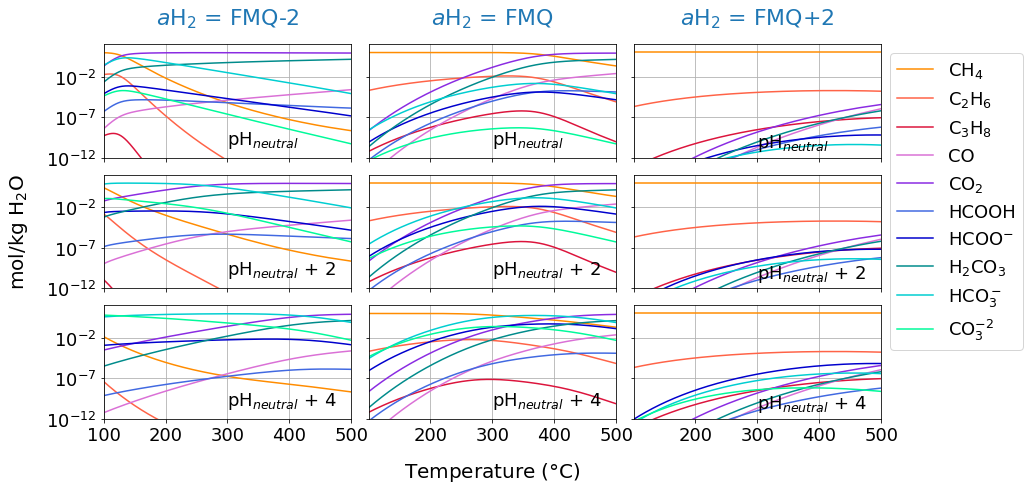

In [49]:
#Plot only species in major species list:
#1. All subplots together:

fig5 = plt.figure(9)
ax = plt.subplot(331) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,0], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
#plt.ylabel('mol/kg H$_2$O')
plt.xlim(100, 500)
plt.ylim(1e-12,1e2)
ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(300, 5e-11, r'pH$_{neutral}$',size = 18)
plt.title(r'$a$H$_2$ = FMQ-2', color = '#1f77b4')

ax = plt.subplot(332) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,0], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(1e-12,1e2)
ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(300, 5e-11, r'pH$_{neutral}$',size = 18)
plt.title(r'$a$H$_2$ = FMQ', color = '#1f77b4')

ax = plt.subplot(333) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,0], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(1e-12,1e2)
ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(300, 2e-11, r'pH$_{neutral}$',size = 18)
plt.legend(bbox_to_anchor=(1,1), prop={'size': 18})
plt.title(r'$a$H$_2$ = FMQ+2', color = '#1f77b4')

ax = plt.subplot(334) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,1], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(100, 500)
plt.ylim(1e-12,1e2)
ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(300, 5e-11, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(335) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,1], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(1e-12,1e2)
ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(300, 5e-11, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(336) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,1], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(1e-12,1e2)
ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(300, 2e-11, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(337) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][0,2], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
#plt.ylabel('mol/kg H$_2$O')
plt.xlim(100, 500)
plt.ylim(1e-12,1e2)
#plt.xlabel('Temperature ($\degree$C)')
ax.set_yscale('log')
plt.grid()
plt.text(300, 5e-11, r'pH$_{neutral}$ + 4',size = 18)

ax = plt.subplot(338) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][1,2], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(1e-12,1e2)
plt.xticks([200,300,400,500])
plt.xlabel('Temperature ($\degree$C)')
ax.set_yscale('log')
plt.grid()
plt.text(300, 5e-11, r'pH$_{neutral}$ + 4',size = 18)
plt.setp(ax.get_yticklabels(), visible=False)

ax = plt.subplot(339) 
for species_name in log_major_species:
    if species_name != 'C4H10':
        plt.plot(T,carbon_species[species_name][2,2], label = carbon_species[species_name + '_l'], color = carbon_species[species_name + '_c'])
plt.xlim(100, 500)
plt.ylim(1e-12,1e2)
plt.xticks([200,300,400,500])
ax.set_yscale('log')
plt.grid()
plt.text(300, 2e-11, r'pH$_{neutral}$ + 4',size = 18)
plt.setp(ax.get_yticklabels(), visible=False)
#plt.xlabel('Temperature ($\degree$C)')
plt.subplots_adjust(left = 1.0, bottom=0.7, right=2.8, top=2,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Carbon/all_1500bar_log.png', bbox_inches = 'tight')



In [50]:
#Affinity:
def A(T, K, Q): #temperatures in Celsius
	R = 8.31446 #J mol^-1 K^-1
	A = (2.3026 * R * (T+273.15) * (K - Q))/1000.0 #kJ/mol
	return A

#Affinities: Methanogenesis
#'4H2 + CO2 = CH4 + 2H2O
# at T = 0,100,200,300,400,500, from DEW:
#Kmeth = np.array([39.090765, 26.718334, 18.275548, 12.057239, 7.154357, 3.021471])
# N, T, P, K_meth = np.loadtxt('Europa_K/methanogenesis.txt', skiprows=9, unpack=True)
H2O = 1.0
#Concentrations at FMQ and pH neutral:
# temps = np.array([0.01,100,200,300,400,500])
# CH4_a = np.zeros(len(temps))
# CO2_a = np.zeros(len(temps))
# H2_a = np.zeros(len(temps))
# for i in range(0,len(temps)):
#     CH4_a[i] = CH4[1,0][np.where(T==temps[i])]
#     CO2_a[i] = CO2[1,0][np.where(T==temps[i])]
#     H2_a[i] = aH2[1][np.where(T==temps[i])]    
# Q_meth_a = np.log10(CH4_a) + 2*np.log10(H2O) - np.log10(CO2_a) - 4*H2_a    
# Ameth_a = A(temps, Kmeth, Q_meth_a)
#Calculate affinity for methanogenesis at all conditions 
# Q_meth = np.zeros([len(aH2), len(pH),len(T)])
# A_meth = np.zeros([len(aH2), len(pH),len(T)])
# for i in range(0, len(aH2)):
#     for j in range(0, len(pH)):
#         Q_meth[i,j] = np.log10(CH4[i,j]) + 2*np.log10(H2O) - np.log10(CO2[i,j]) - 4*aH2[i]
#         A_meth[i,j] = A(T, K_meth, Q_meth[i,j])
        
        

In [51]:
#Since everything is in equilibrium in the vent fluid, we will have to use the global ocean...
#If the global ocean is more oxidized than the vents....

#From Hand (2007):
#O2 = np.logspace(-18,-12,10) #mol/kg H2O
O2 = np.logspace(-6,-2,10) #mol/kg H2O
#Methane Oxidation: 0.5CH4 + O2 = 0.5CO2 + H2O'
#Q = [CO2]^(1/2) * [H2O]/ [O2]*[CH4]^(1/2) = ([CO2]/[CH4])^(1/2) * 1/[O2]
#Calcuate the CO2/CH4 ratio for all conditions:
CO2_CH4 = np.zeros([len(aH2), len(pH),len(T)])
for i in range(0, len(aH2)):
    for j in range(0, len(pH)):
        CO2_CH4[i,j] = CO2[i,j]/CH4[i,j]
log_K = 82.53082 #at zero degrees in the ocean

#First, calculate what the affinity would be for vent fluid at pH neutral and FMQ (a):
temps = np.array([0.01,100,200,300,400,500])
Q_a = np.zeros([len(temps),len(O2)])
for i in range(0,len(temps)):
    Q_a[i] = (CO2_CH4[1,0][np.where(T==temps[i])])*(1/O2)
log_Qa = np.log10(Q_a)
A_a = A(0, log_K, log_Qa)
#0.5*np.log10(CO2[0]) + np.log10(H2O) - 0.5*np.log10(CH4[0]) - np.log10(O2_I)), 

#And now for all conditions: four dimensional arrays wooooowee!
Q_methox = np.zeros([len(aH2),len(pH),len(temps), len(O2)])
for i in range(0, len(aH2)):
    for j in range(0, len(pH)):
        for k in range(0,len(temps)):
            Q_methox[i,j,k] = (CO2_CH4[i,j][np.where(T==temps[k])])*(1/O2)
log_Qmethox = np.log10(Q_methox)
A_methox = A(0, log_K, log_Qmethox)

#Hydrogen oxidation: 2H2 + O2 -> 2H2O
#logK = -2log(H2) - log(O2)
# logK_H2ox = 102.0762
# Q_H2ox = np.zeros([len(aH2),len(pH),len(temps), len(O2)])
# for i in range(0, len(aH2)):
#     for j in range(0, len(pH)):
#         for k in range(0,len(temps)):
#             Q_H2ox[i,j,k] = (CO2_CH4[i,j][np.where(T==temps[k])])*(1/O2)
# log_QH2ox = np.log10(Q_H2ox)
# A_H2ox = A(0, logK_H2ox, log_QH2ox)

In [52]:
#And methanogenesis: 4H2 + CO2 = CH4 + 2H2O     
#Q = [CH4]/[CO2] * [aH2]^-4
#So all we need is a constraint on hydrogen activity in the ocean...
#Let's assume O2 and H2 are in equilibrium in the ocean? Idk
#for O2 + 2H2 -> 2H2O
#log K = -log(O2) - 2log(H2) -> log(H2) = 1/2 * (-log(O2) - logK)
logK_H2O = 102.0762
logH2_ocean = 0.5*(-np.log10(O2) - logK_H2O)

#This seems really low. Our FMQ reference points go from -8 to 1, so let's use that at the upper end and O2 equilibrium at the lower end:
H2 = np.logspace(-50,1,10) #mol/kg H2O
logK_methan = 39.09077
Q_methan = np.zeros([len(aH2),len(pH),len(temps), len(H2)])
for i in range(0, len(aH2)):
    for j in range(0, len(pH)):
        for k in range(0,len(temps)):
            Q_methan[i,j,k] = (CO2_CH4[i,j][np.where(T==temps[k])])*(H2**-4)
log_Qmethan = np.log10(Q_methan)
A_methan = A(0, logK_methan, log_Qmethan)

In [53]:
logH2_ocean

array([-48.0381    , -48.26032222, -48.48254444, -48.70476667,
       -48.92698889, -49.14921111, -49.37143333, -49.59365556,
       -49.81587778, -50.0381    ])

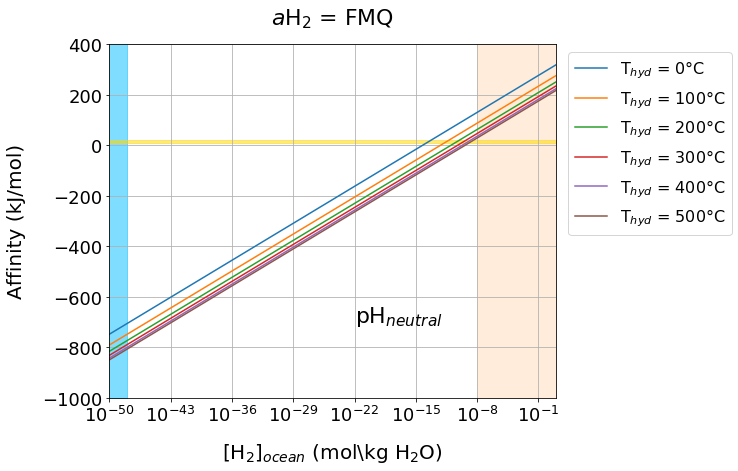

In [54]:
#Now plot affinity vs. oxidation state in the ocean

# fig1 = plt.figure(1)
# fig1.set_figheight(6.5)
# fig1.set_figwidth(8)
# #ax = plt.subplot(331) 
# plt.plot(O2, A_a[0], label = r'T$_{hyd}$ = 0$\degree$C')
# plt.plot(O2, A_a[1], label = r'T$_{hyd}$ = 100$\degree$C')
# plt.plot(O2, A_a[2], label = r'T$_{hyd}$ = 200$\degree$C')
# plt.plot(O2, A_a[3], label = r'T$_{hyd}$ = 300$\degree$C')
# plt.plot(O2, A_a[4], label = r'T$_{hyd}$ = 400$\degree$C')
# plt.plot(O2, A_a[5], label = r'T$_{hyd}$ = 500$\degree$C')
# plt.ylabel('Affinity (kJ/mol)')
# plt.xlim(1e-6,1e-2)
# plt.ylim(350,550)
# #plt.setp(ax.get_xticklabels(), visible=False)
# plt.grid()
# plt.text(6e-4, 375, r'pH$_{neutral}$',size = 22)
# plt.title(r'$a$H$_2$ = FMQ')
# plt.xlabel(r'[O$_2$]$_{ocean}$ (mol\kg H$_2$O)')
# plt.xscale('log')
# #plt.subplots_adjust(left = 1.0, bottom=0.7, right=2.8, top=2,
# #                 wspace=0.07, hspace=0.15)
# plt.legend(bbox_to_anchor=(1,1), prop={'size': 16})

# plt.savefig('Speciation_Plots/Carbon/methox_aff_one.png', bbox_inches = 'tight')

fig2 = plt.figure(2)
fig2.set_figheight(6.5)
fig2.set_figwidth(8)
#ax = plt.subplot(331) 
plt.plot(H2, A_methan[1,0,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[1,0,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[1,0,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[1,0,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[1,0,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[1,0,5], label = r'T$_{hyd}$ = 500$\degree$C')

#Add some shading:
#The hydrothermal upper limit:
y = [-1000,400]
plt.fill_betweenx(y,1e-50,1e-48, alpha=0.5, color='deepskyblue')
plt.fill_betweenx(y,1e-8,1e1, alpha=0.5, color='peachpuff')

plt.fill_between(H2, 10,20, alpha = 0.5, color = 'gold')
plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
#plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
#plt.text(6e-4, 375, r'pH$_{neutral}$',size = 22)
plt.title(r'$a$H$_2$ = FMQ')
plt.xlabel(r'[H$_2$]$_{ocean}$ (mol\kg H$_2$O)')
plt.xscale('log')
#plt.subplots_adjust(left = 1.0, bottom=0.7, right=2.8, top=2,
#                 wspace=0.07, hspace=0.15)
plt.text(1e-22, -700, r'pH$_{neutral}$',size = 22)
plt.legend(bbox_to_anchor=(1.01,1), prop={'size': 16})

plt.savefig('Speciation_Plots/Carbon/methan_aff_shadeboth.png', bbox_inches = 'tight')

plt.show()

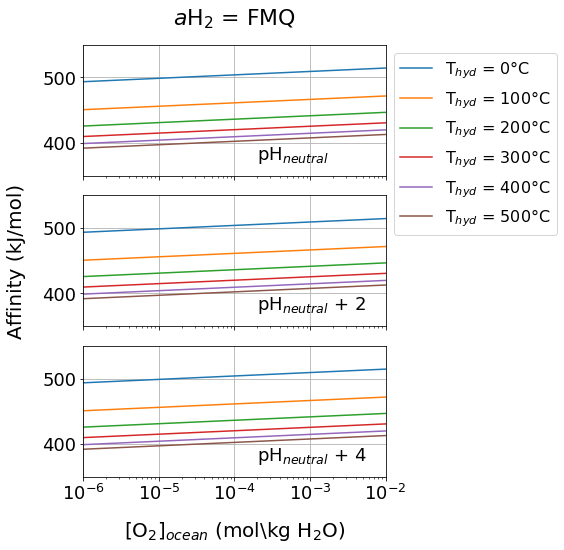

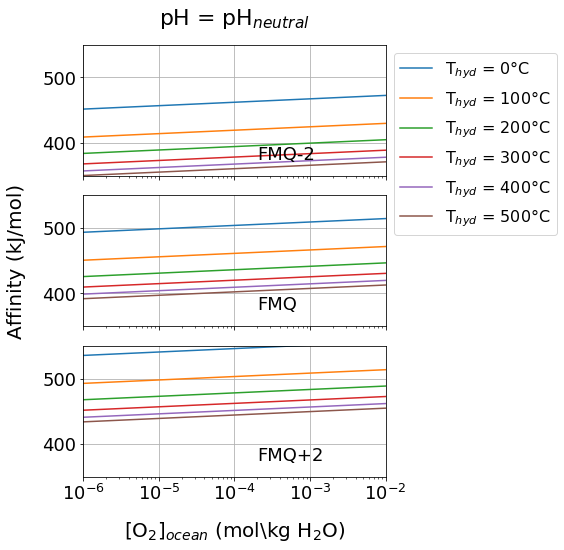

In [55]:
#And for all considered conditions:

fig1 = plt.figure(1)

ax = plt.subplot(311) 
plt.plot(O2, A_methox[1,0,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[1,0,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[1,0,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[1,0,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[1,0,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[1,0,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(350,550)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(2e-4, 375, r'pH$_{neutral}$',size = 18)
plt.title(r'$a$H$_2$ = FMQ')
plt.legend(bbox_to_anchor=(1,1), prop={'size': 16})


ax = plt.subplot(312) 
plt.plot(O2, A_methox[1,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[1,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[1,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[1,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[1,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[1,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(350,550)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(2e-4, 375, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(313) 
plt.plot(O2, A_methox[1,2,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[1,2,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[1,2,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[1,2,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[1,2,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[1,2,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(350,550)
ax.set_xscale('log')
plt.grid()
plt.text(2e-4, 375, r'pH$_{neutral}$ + 4',size = 18)
plt.xlabel(r'[O$_2$]$_{ocean}$ (mol\kg H$_2$O)')

plt.subplots_adjust(left = 1.0, bottom=0.7, right=1.7, top=2.2,
                 wspace=0.07, hspace=0.15)

plt.savefig('Speciation_Plots/Carbon/methox_aff_three.png', bbox_inches = 'tight')

fig2 = plt.figure(2)

ax = plt.subplot(311) 
plt.plot(O2, A_methox[0,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[0,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[0,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[0,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[0,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[0,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(350,550)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(2e-4, 375, 'FMQ-2',size = 18)
plt.title(r'pH = pH$_{neutral}$')
plt.legend(bbox_to_anchor=(1,1), prop={'size': 16})


ax = plt.subplot(312) 
plt.plot(O2, A_methox[1,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[1,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[1,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[1,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[1,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[1,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(350,550)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(2e-4, 375, 'FMQ',size = 18)

ax = plt.subplot(313) 
plt.plot(O2, A_methox[2,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[2,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[2,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[2,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[2,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[2,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(350,550)
ax.set_xscale('log')
plt.grid()
plt.text(2e-4, 375, r'FMQ+2',size = 18)
plt.xlabel(r'[O$_2$]$_{ocean}$ (mol\kg H$_2$O)')

plt.subplots_adjust(left = 1.0, bottom=0.7, right=1.7, top=2.2,
                 wspace=0.07, hspace=0.15)

plt.savefig('Speciation_Plots/Carbon/methox_aff_threenopH.png', bbox_inches = 'tight')



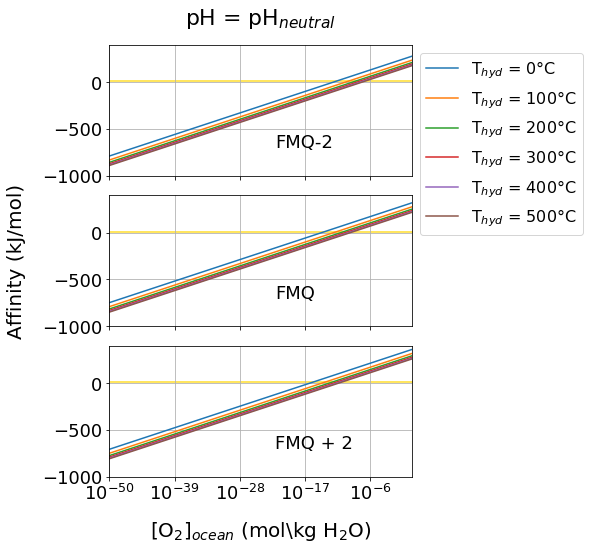

In [56]:
fig2 = plt.figure(2)

ax = plt.subplot(311) 
plt.plot(H2, A_methan[0,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[0,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[0,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[0,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[0,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[0,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
plt.fill_between(H2, 10,20, alpha = 0.5, color = 'gold')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(1e-22, -700, 'FMQ-2',size = 18)
plt.title(r'pH = pH$_{neutral}$')
plt.legend(bbox_to_anchor=(1,1), prop={'size': 16})


ax = plt.subplot(312) 
plt.plot(H2, A_methan[1,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[1,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[1,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[1,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[1,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[1,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
plt.fill_between(H2, 10,20, alpha = 0.5, color = 'gold')
plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(1e-22, -700, r'FMQ',size = 18)

ax = plt.subplot(313) 
plt.plot(H2, A_methan[2,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[2,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[2,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[2,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[2,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[2,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.fill_between(H2, 10,20, alpha = 0.5, color = 'gold')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
ax.set_xscale('log')
plt.grid()
plt.text(1e-22, -700, 'FMQ + 2',size = 18)
plt.xlabel(r'[O$_2$]$_{ocean}$ (mol\kg H$_2$O)')

plt.subplots_adjust(left = 1.0, bottom=0.7, right=1.7, top=2.2,
                 wspace=0.07, hspace=0.15)

plt.savefig('Speciation_Plots/Carbon/methan_aff_three.png', bbox_inches = 'tight')

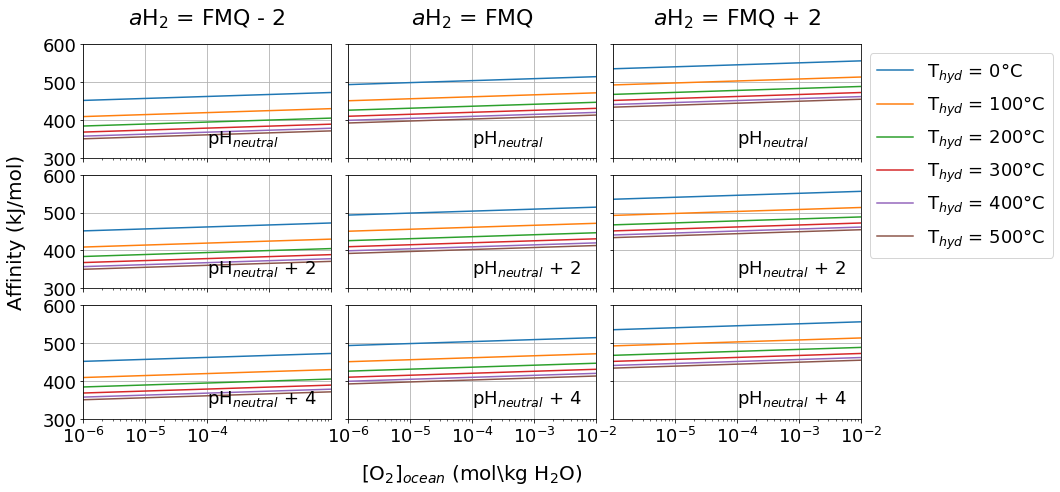

In [57]:
#And for all considered conditions:

fig1 = plt.figure(1)

ax = plt.subplot(331) 
plt.plot(O2, A_methox[0,0,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[0,0,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[0,0,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[0,0,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[0,0,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[0,0,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(300,600)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$',size = 18)
plt.title(r'$a$H$_2$ = FMQ - 2')


ax = plt.subplot(332) 
plt.plot(O2, A_methox[1,0,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[1,0,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[1,0,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[1,0,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[1,0,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[1,0,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(300,600)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$',size = 18)
plt.title(r'$a$H$_2$ = FMQ')

ax = plt.subplot(333) 
plt.plot(O2, A_methox[2,0,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[2,0,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[2,0,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[2,0,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[2,0,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[2,0,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(300,600)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$',size = 18)
plt.title(r'$a$H$_2$ = FMQ + 2')
plt.legend(bbox_to_anchor=(1,1), prop={'size': 18})

ax = plt.subplot(334) 
plt.plot(O2, A_methox[0,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[0,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[0,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[0,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[0,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[0,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(300,600)
plt.ylabel('Affinity (kJ/mol)')
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(335) 
plt.plot(O2, A_methox[1,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[1,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[1,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[1,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[1,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[1,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
plt.xlim(1e-6,1e-2)
plt.ylim(300,600)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(336) 
plt.plot(O2, A_methox[2,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[2,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[2,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[2,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[2,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[2,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
plt.xlim(1e-6,1e-2)
plt.ylim(300,600)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(337) 
plt.plot(O2, A_methox[0,2,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[0,2,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[0,2,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[0,2,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[0,2,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[0,2,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(300,600)
ax.set_xscale('log')
plt.xticks([1e-6,1e-5, 1e-4])
#plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 4',size = 18)
#plt.xlabel(r'[O$_2$]$_{ocean}$ (mol\kg H$_2$O)')


ax = plt.subplot(338) 
plt.plot(O2, A_methox[1,2,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[1,2,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[1,2,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[1,2,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[1,2,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[1,2,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(300,600)
ax.set_xscale('log')
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 4',size = 18)
plt.xlabel(r'[O$_2$]$_{ocean}$ (mol\kg H$_2$O)')

ax = plt.subplot(339) 
plt.plot(O2, A_methox[2,2,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(O2, A_methox[2,2,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(O2, A_methox[2,2,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(O2, A_methox[2,2,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(O2, A_methox[2,2,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(O2, A_methox[2,2,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-6,1e-2)
plt.ylim(300,600)
ax.set_xscale('log')
plt.xticks([1e-5,1e-4, 1e-3, 1e-2])
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 4',size = 18)
#plt.xlabel(r'[O$_2$]$_{ocean}$ (mol\kg H$_2$O)')

plt.subplots_adjust(left = 1.0, bottom=0.7, right=2.8, top=2,
                 wspace=0.07, hspace=0.15)


#plt.savefig('Speciation_Plots/Carbon/methox_aff_all_highO2.png', bbox_inches = 'tight')
plt.savefig('Speciation_Plots/Carbon/methox_aff_all_lowO2.png', bbox_inches = 'tight')

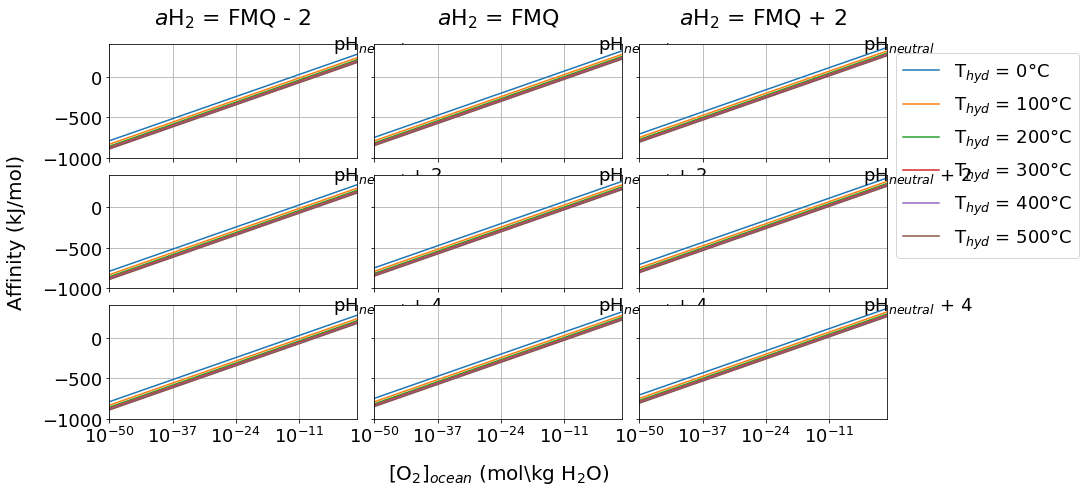

In [58]:
#And for all considered conditions:

fig1 = plt.figure(1)

ax = plt.subplot(331) 
plt.plot(H2, A_methan[0,0,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[0,0,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[0,0,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[0,0,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[0,0,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[0,0,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$',size = 18)
plt.title(r'$a$H$_2$ = FMQ - 2')


ax = plt.subplot(332) 
plt.plot(H2, A_methan[1,0,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[1,0,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[1,0,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[1,0,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[1,0,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[1,0,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$',size = 18)
plt.title(r'$a$H$_2$ = FMQ')

ax = plt.subplot(333) 
plt.plot(H2, A_methan[2,0,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[2,0,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[2,0,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[2,0,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[2,0,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[2,0,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$',size = 18)
plt.title(r'$a$H$_2$ = FMQ + 2')
plt.legend(bbox_to_anchor=(1,1), prop={'size': 18})

ax = plt.subplot(334) 
plt.plot(H2, A_methan[0,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[0,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[0,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[0,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[0,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[0,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
plt.ylabel('Affinity (kJ/mol)')
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(335) 
plt.plot(H2, A_methan[1,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[1,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[1,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[1,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[1,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[1,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(336) 
plt.plot(H2, A_methan[2,1,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[2,1,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[2,1,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[2,1,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[2,1,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[2,1,5], label = r'T$_{hyd}$ = 500$\degree$C')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 2',size = 18)

ax = plt.subplot(337) 
plt.plot(H2, A_methan[0,2,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[0,2,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[0,2,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[0,2,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[0,2,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[0,2,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
ax.set_xscale('log')
#plt.xticks([1e-6,1e-5, 1e-4, 1e-3])
#plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 4',size = 18)
#plt.xlabel(r'[O$_2$]$_{ocean}$ (mol\kg H$_2$O)')


ax = plt.subplot(338) 
plt.plot(H2, A_methan[1,2,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[1,2,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[1,2,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[1,2,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[1,2,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[1,2,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
ax.set_xscale('log')
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 4',size = 18)
plt.xlabel(r'[O$_2$]$_{ocean}$ (mol\kg H$_2$O)')

ax = plt.subplot(339) 
plt.plot(H2, A_methan[2,2,0], label = r'T$_{hyd}$ = 0$\degree$C')
plt.plot(H2, A_methan[2,2,1], label = r'T$_{hyd}$ = 100$\degree$C')
plt.plot(H2, A_methan[2,2,2], label = r'T$_{hyd}$ = 200$\degree$C')
plt.plot(H2, A_methan[2,2,3], label = r'T$_{hyd}$ = 300$\degree$C')
plt.plot(H2, A_methan[2,2,4], label = r'T$_{hyd}$ = 400$\degree$C')
plt.plot(H2, A_methan[2,2,5], label = r'T$_{hyd}$ = 500$\degree$C')
#plt.ylabel('Affinity (kJ/mol)')
plt.xlim(1e-50,1e1)
plt.ylim(-1000,400)
ax.set_xscale('log')
#plt.xticks([1e-5,1e-4, 1e-3, 1e-2])
plt.setp(ax.get_yticklabels(), visible=False)
plt.grid()
plt.text(1e-4, 340, r'pH$_{neutral}$ + 4',size = 18)
#plt.xlabel(r'[O$_2$]$_{ocean}$ (mol\kg H$_2$O)')

plt.subplots_adjust(left = 1.0, bottom=0.7, right=2.8, top=2,
                 wspace=0.07, hspace=0.15)


#plt.savefig('Speciation_Plots/Carbon/methox_aff_all_highH2.png', bbox_inches = 'tight')
plt.savefig('Speciation_Plots/Carbon/methan_aff_all.png', bbox_inches = 'tight')

In [59]:
# #Now plot concentration vs. carbon number for alkanes
# x = np.array([1,2,3,4])
# plt.rcParams['axes.labelpad'] = 3 

# #T = 150
# fig10 = plt.figure(10)
# ax = plt.subplot(331)
# plt.plot(x,np.array([carbon_species['CH4'][0,0,0],carbon_species['C2H6'][0,0,0], carbon_species['C3H8'][0,0,0], carbon_species['C4H10'][0,0,0]]))
# plt.plot(x,np.array([carbon_species['CH4'][0,0,15],carbon_species['C2H6'][0,0,15], carbon_species['C3H8'][0,0,15], carbon_species['C4H10'][0,0,15]]))
# plt.plot(x,np.array([carbon_species['CH4'][0,0,25],carbon_species['C2H6'][0,0,25], carbon_species['C3H8'][0,0,25], carbon_species['C4H10'][0,0,25]]))
# plt.plot(x,np.array([carbon_species['CH4'][0,0,35],carbon_species['C2H6'][0,0,35], carbon_species['C3H8'][0,0,35], carbon_species['C4H10'][0,0,35]]))
# plt.ylabel('mol/kg H$_2$O')
# plt.xlim(1, 4)
# plt.ylim(1e-14,1e2)
# ax.set_yscale('log')
# plt.setp(ax.get_xticklabels(), visible=False)
# plt.grid()
# plt.text(2.6, 1e-1, r'pH$_{neutral}$',size = 18)
# plt.title(r'$a$H$_2$ = FMQ-2')

# ax = plt.subplot(332) 
# plt.plot(x,np.array([carbon_species['CH4'][1,0,0],carbon_species['C2H6'][1,0,0], carbon_species['C3H8'][1,0,0], carbon_species['C4H10'][1,0,0]]))
# plt.plot(x,np.array([carbon_species['CH4'][1,0,15],carbon_species['C2H6'][1,0,15], carbon_species['C3H8'][1,0,15], carbon_species['C4H10'][1,0,15]]))
# plt.plot(x,np.array([carbon_species['CH4'][1,0,25],carbon_species['C2H6'][1,0,25], carbon_species['C3H8'][1,0,25], carbon_species['C4H10'][1,0,25]]))
# plt.plot(x,np.array([carbon_species['CH4'][1,0,35],carbon_species['C2H6'][1,0,35], carbon_species['C3H8'][1,0,35], carbon_species['C4H10'][1,0,35]]))
# plt.xlim(1, 4)
# plt.ylim(1e-14,1e2)
# ax.set_yscale('log')
# plt.setp(ax.get_xticklabels(), visible=False)
# plt.setp(ax.get_yticklabels(), visible=False)
# plt.grid()
# plt.text(2.6, 1e-1, r'pH$_{neutral}$',size = 18)
# plt.title(r'$a$H$_2$ = FMQ')

# ax = plt.subplot(333) 
# plt.plot(x,np.array([carbon_species['CH4'][2,0,0],carbon_species['C2H6'][2,0,0], carbon_species['C3H8'][2,0,0], carbon_species['C4H10'][2,0,0]]), label = r'T = 150$\degree$C')
# plt.plot(x,np.array([carbon_species['CH4'][2,0,15],carbon_species['C2H6'][2,0,15], carbon_species['C3H8'][2,0,15], carbon_species['C4H10'][2,0,15]]), label = r'T = 300$\degree$C')
# plt.plot(x,np.array([carbon_species['CH4'][2,0,25],carbon_species['C2H6'][2,0,25], carbon_species['C3H8'][2,0,25], carbon_species['C4H10'][2,0,25]]), label = r'T = 400$\degree$C')
# plt.plot(x,np.array([carbon_species['CH4'][2,0,35],carbon_species['C2H6'][2,0,35], carbon_species['C3H8'][2,0,35], carbon_species['C4H10'][2,0,35]]), label = r'T = 500$\degree$C')
# plt.xlim(1, 4)
# plt.ylim(1e-14,1e2)
# ax.set_yscale('log')
# plt.setp(ax.get_xticklabels(), visible=False)
# plt.setp(ax.get_yticklabels(), visible=False)
# plt.grid()
# plt.text(2.6, 1e-1, r'pH$_{neutral}$',size = 18)
# plt.legend(bbox_to_anchor=(1,1), prop={'size': 18})
# plt.title(r'$a$H$_2$ = FMQ+2')

# ax = plt.subplot(334) 
# plt.plot(x,np.array([carbon_species['CH4'][0,1,0],carbon_species['C2H6'][0,1,0], carbon_species['C3H8'][0,1,0], carbon_species['C4H10'][0,1,0]]))
# plt.plot(x,np.array([carbon_species['CH4'][0,1,15],carbon_species['C2H6'][0,1,15], carbon_species['C3H8'][0,1,15], carbon_species['C4H10'][0,1,15]]))
# plt.plot(x,np.array([carbon_species['CH4'][0,1,25],carbon_species['C2H6'][0,1,25], carbon_species['C3H8'][0,1,15], carbon_species['C4H10'][0,1,25]]))
# plt.plot(x,np.array([carbon_species['CH4'][0,1,35],carbon_species['C2H6'][0,1,35], carbon_species['C3H8'][0,1,35], carbon_species['C4H10'][0,1,35]]))
# plt.ylabel('mol/kg H$_2$O')
# plt.xlim(1, 4)
# plt.ylim(1e-14,1e2)
# ax.set_yscale('log')
# plt.setp(ax.get_xticklabels(), visible=False)
# plt.grid()
# plt.text(2.6, 1e-1, r'pH$_{neutral}$ + 2',size = 18)

# ax = plt.subplot(335) 
# plt.plot(x,np.array([carbon_species['CH4'][1,1,0],carbon_species['C2H6'][1,1,0], carbon_species['C3H8'][1,1,0], carbon_species['C4H10'][1,1,0]]))
# plt.plot(x,np.array([carbon_species['CH4'][1,1,15],carbon_species['C2H6'][1,1,15], carbon_species['C3H8'][1,1,15], carbon_species['C4H10'][1,1,15]]))
# plt.plot(x,np.array([carbon_species['CH4'][1,1,25],carbon_species['C2H6'][1,1,25], carbon_species['C3H8'][1,1,25], carbon_species['C4H10'][1,1,25]]))
# plt.plot(x,np.array([carbon_species['CH4'][1,1,35],carbon_species['C2H6'][1,1,35], carbon_species['C3H8'][1,1,35], carbon_species['C4H10'][1,1,35]]))
# plt.xlim(1, 4)
# plt.ylim(1e-14,1e2)
# ax.set_yscale('log')
# plt.setp(ax.get_xticklabels(), visible=False)
# plt.setp(ax.get_yticklabels(), visible=False)
# plt.grid()
# plt.text(2.6, 1e-1, r'pH$_{neutral}$ + 2',size = 18)

# ax = plt.subplot(336) 
# plt.plot(x,np.array([carbon_species['CH4'][2,1,0],carbon_species['C2H6'][2,1,0], carbon_species['C3H8'][2,1,0], carbon_species['C4H10'][2,1,0]]))
# plt.plot(x,np.array([carbon_species['CH4'][2,1,15],carbon_species['C2H6'][2,1,15], carbon_species['C3H8'][2,1,15], carbon_species['C4H10'][2,1,15]]))
# plt.plot(x,np.array([carbon_species['CH4'][2,1,25],carbon_species['C2H6'][2,1,25], carbon_species['C3H8'][2,1,25], carbon_species['C4H10'][2,1,25]]))
# plt.plot(x,np.array([carbon_species['CH4'][2,1,35],carbon_species['C2H6'][2,1,35], carbon_species['C3H8'][2,1,35], carbon_species['C4H10'][2,1,35]]))
# plt.xlim(1, 4)
# plt.ylim(1e-14,1e2)
# ax.set_yscale('log')
# plt.setp(ax.get_xticklabels(), visible=False)
# plt.setp(ax.get_yticklabels(), visible=False)
# plt.grid()
# plt.text(2.6, 1e-1, r'pH$_{neutral}$ + 2',size = 18)

# ax = plt.subplot(337) 
# plt.plot(x,np.array([carbon_species['CH4'][0,2,0],carbon_species['C2H6'][0,2,0], carbon_species['C3H8'][0,2,0], carbon_species['C4H10'][0,2,0]]))
# plt.plot(x,np.array([carbon_species['CH4'][0,2,15],carbon_species['C2H6'][0,2,15], carbon_species['C3H8'][0,2,15], carbon_species['C4H10'][0,2,15]]))
# plt.plot(x,np.array([carbon_species['CH4'][0,2,25],carbon_species['C2H6'][0,2,25], carbon_species['C3H8'][0,2,25], carbon_species['C4H10'][0,2,25]]))
# plt.plot(x,np.array([carbon_species['CH4'][0,2,35],carbon_species['C2H6'][0,2,35], carbon_species['C3H8'][0,2,35], carbon_species['C4H10'][0,2,35]]))
# plt.ylabel('mol/kg H$_2$O')
# plt.xlim(1, 4)
# plt.ylim(1e-14,1e2)
# ax.set_yscale('log')
# plt.grid()
# plt.xlabel('Carbon Number')
# plt.text(2.6, 1e-1, r'pH$_{neutral}$ + 4',size = 18)

# ax = plt.subplot(338) 
# plt.plot(x,np.array([carbon_species['CH4'][1,2,0],carbon_species['C2H6'][1,2,0], carbon_species['C3H8'][1,2,0], carbon_species['C4H10'][1,2,0]]))
# plt.plot(x,np.array([carbon_species['CH4'][1,2,15],carbon_species['C2H6'][1,2,15], carbon_species['C3H8'][1,2,15], carbon_species['C4H10'][1,2,15]]))
# plt.plot(x,np.array([carbon_species['CH4'][1,2,25],carbon_species['C2H6'][1,2,25], carbon_species['C3H8'][1,2,25], carbon_species['C4H10'][1,2,25]]))
# plt.plot(x,np.array([carbon_species['CH4'][1,2,35],carbon_species['C2H6'][1,2,35], carbon_species['C3H8'][1,2,35], carbon_species['C4H10'][1,2,35]]))
# plt.xlim(1, 4)
# plt.ylim(1e-14,1e2)
# ax.set_yscale('log')
# plt.grid()
# plt.xlabel('Carbon Number')
# plt.text(2.6, 1e-1, r'pH$_{neutral}$ + 4',size = 18)
# plt.setp(ax.get_yticklabels(), visible=False)

# ax = plt.subplot(339) 
# plt.plot(x,np.array([carbon_species['CH4'][2,2,0],carbon_species['C2H6'][2,2,0], carbon_species['C3H8'][2,2,0], carbon_species['C4H10'][2,2,0]]))
# plt.plot(x,np.array([carbon_species['CH4'][2,2,15],carbon_species['C2H6'][2,2,15], carbon_species['C3H8'][2,2,15], carbon_species['C4H10'][2,2,15]]))
# plt.plot(x,np.array([carbon_species['CH4'][2,2,25],carbon_species['C2H6'][2,2,25], carbon_species['C3H8'][2,2,25], carbon_species['C4H10'][2,2,25]]))
# plt.plot(x,np.array([carbon_species['CH4'][2,2,35],carbon_species['C2H6'][2,2,35], carbon_species['C3H8'][2,2,35], carbon_species['C4H10'][2,2,35]]))
# plt.xlim(1, 4)
# plt.ylim(1e-14,1e2)
# ax.set_yscale('log')
# plt.grid()
# plt.xlabel('Carbon Number')
# plt.text(2.6, 1e-1, r'pH$_{neutral}$ + 4',size = 18)
# plt.setp(ax.get_yticklabels(), visible=False)

# plt.subplots_adjust(left = 1.0, bottom=0.7, right=2.8, top=2,
#                  wspace=0.07, hspace=0.15)
# #plt.show()
# plt.savefig('Speciation_Plots/Carbon/carbonnumber150.png', bbox_inches = 'tight')



In [60]:
#Nitrogen Speciation:
#Plot stable carbon species at T = 500, P = 1500 bar
pH = np.arange(0,15,0.01)
T = np.array([300, 400, 500, 600, 700])
Sigma_N = 0.719 #mol/kg H2O, from Lodders (2003) & Alexander (2019)

#1) 2NH3 -> N2 + 3H2, horizontal line
K1 = np.array([-6.7763674, -2.7469225, 0.8905725, 4.4262058, 7.9503615])
aH2_1 = (1/3)*(K1+np.log10((1/3)*Sigma_N))

#2) 2NH4 -> N2 + 2H+ + 3H2
K2 = np.array([-16.612753, -11.058250, -6.215098, -1.631775, 2.877686])
aH2_2 = np.zeros([len(T), len(pH)])
for i in range(0,len(T)):
    aH2_2[i] = (1/3)*(K2[i] + 2*pH + np.log10((1/3)*Sigma_N))

#3) NH4 -> NH3 + H+, vertical line
K3 = np.array([-4.918193, -4.155664, -3.552835, -3.028991, -2.536338])
pH_3 = -K3


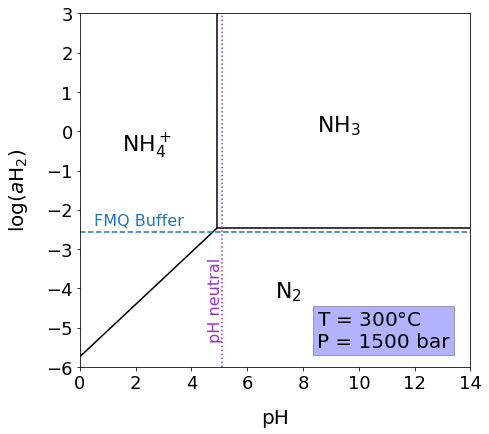

NameError: name 'FMQ_600' is not defined

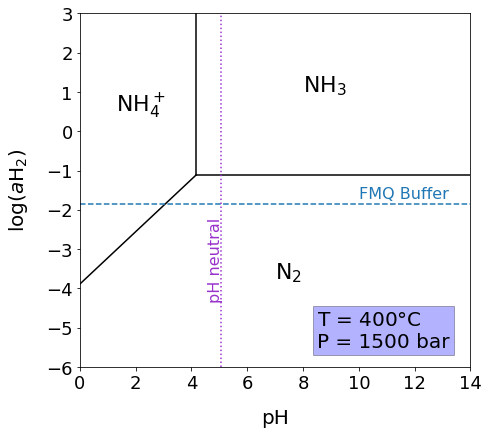

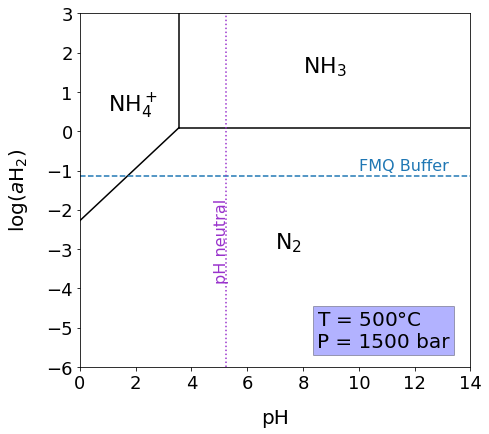

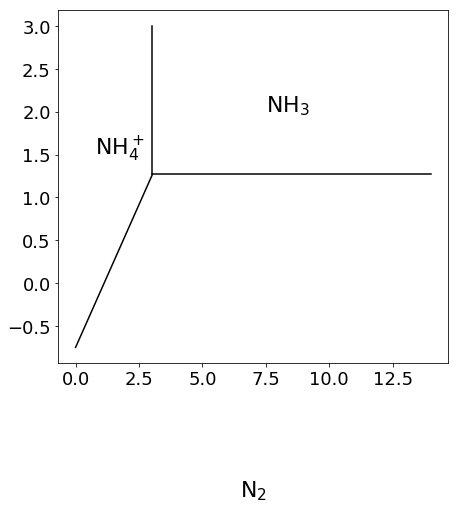

In [61]:
#T = 300
fig1 = plt.figure(1)
fig1.set_figheight(6.5)
fig1.set_figwidth(7)
plt.clf()
#N2 -> NH3]
plt.plot([pH_3[0],14],[aH2_1[0],aH2_1[0]], label = r'N$_2 \rightarrow$ NH$_3$', color = 'k')
#N2 -> NH4
plt.plot(pH[pH<pH_3[0]], aH2_2[0][aH2_2[0]<aH2_1[0]], label = r'N$_2 \rightarrow$ NH$_4$', color = 'k')
#plt.plot(pH, aH2_2[0], label = r'N$_2 \rightarrow$ NH$_4$')#, color = 'k')
# #NH3 - NH4
plt.plot([pH_3[0],pH_3[0]], [aH2_1[0],3], label = r'NH$_3 \rightarrow$ NH$_4$', color = 'k')
#Labels:
plt.text(7,-4.25, 'N$_2$', size=22)
plt.text(1.5,-0.5, 'NH$_4^+$', size=22)
plt.text(8.5,0, 'NH$_3$', size=22)
# plt.text(11.75,-3.5, 'CO$_3^{-2}$', size=22, rotation=90)
#FMQ buffer
plt.axhline(y=FMQ_300,linestyle='--')
plt.text(0.5,-2.4,'FMQ Buffer', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_300, linestyle = ':', color = 'darkorchid')
plt.text(4.6,-3.5,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
#T & P label:
plt.text(8.5, -5.5, 'T = 300$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,3)
plt.ylabel('log($a$H$_2$)')
#plt.legend(prop={'size': 16})
#plt.grid()
plt.savefig('Speciation_Plots/Nitrogen/activity_300', bbox_inches = 'tight')
plt.show()



#T = 400
fig2 = plt.figure(2)
fig2.set_figheight(6.5)
fig2.set_figwidth(7)
plt.clf()
#N2 -> NH3]
plt.plot([pH_3[1],14],[aH2_1[1],aH2_1[1]], label = r'N$_2 \rightarrow$ NH$_3$', color = 'k')
#N2 -> NH4
plt.plot(pH[pH<pH_3[1]], aH2_2[1][aH2_2[1]<aH2_1[1]], label = r'N$_2 \rightarrow$ NH$_4$', color = 'k')
#plt.plot(pH, aH2_2[1], label = r'N$_2 \rightarrow$ NH$_4$')#, color = 'k')
# #NH3 - NH4
plt.plot([pH_3[1],pH_3[1]], [aH2_1[1],3], label = r'NH$_3 \rightarrow$ NH$_4$', color = 'k')
#Labels:
plt.text(7,-3.75, 'N$_2$', size=22)
plt.text(1.3,0.5, 'NH$_4^+$', size=22)
plt.text(8,1, 'NH$_3$', size=22)
# plt.text(11.75,-3.5, 'CO$_3^{-2}$', size=22, rotation=90)
#FMQ buffer
plt.axhline(y=FMQ_400,linestyle='--')
plt.text(10,-1.7,'FMQ Buffer', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_400, linestyle = ':', color = 'darkorchid')
plt.text(4.6,-2.5,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
#T & P label:
plt.text(8.5, -5.5, 'T = 400$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,3)
plt.ylabel('log($a$H$_2$)')
#plt.legend(prop={'size': 16})
#plt.grid()
plt.savefig('Speciation_Plots/Nitrogen/activity_400', bbox_inches = 'tight')
#plt.show()


#T = 500
fig3 = plt.figure(3)
fig3.set_figheight(6.5)
fig3.set_figwidth(7)
plt.clf()
#N2 -> NH3]
plt.plot([pH_3[2],14],[aH2_1[2],aH2_1[2]], label = r'N$_2 \rightarrow$ NH$_3$', color = 'k')
#N2 -> NH4
plt.plot(pH[pH<pH_3[2]], aH2_2[2][aH2_2[2]<aH2_1[2]], label = r'N$_2 \rightarrow$ NH$_4$', color = 'k')
#plt.plot(pH, aH2_2[2], label = r'N$_2 \rightarrow$ NH$_4$')#, color = 'k')
# #NH3 - NH4
plt.plot([pH_3[2],pH_3[2]], [aH2_1[2],3], label = r'NH$_3 \rightarrow$ NH$_4$', color = 'k')
#Labels:
plt.text(7,-3, 'N$_2$', size=22)
plt.text(1,0.5, 'NH$_4^+$', size=22)
plt.text(8,1.5, 'NH$_3$', size=22)
# plt.text(11.75,-3.5, 'CO$_3^{-2}$', size=22, rotation=90)
#FMQ buffer
plt.axhline(y=FMQ_500,linestyle='--')
plt.text(10,-1,'FMQ Buffer', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_500, linestyle = ':', color = 'darkorchid')
plt.text(4.8,-2,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
#T & P label:
plt.text(8.5, -5.5, 'T = 500$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,3)
plt.ylabel('log($a$H$_2$)')
#plt.legend(prop={'size': 16})
#plt.grid()
plt.savefig('Speciation_Plots/Nitrogen/activity_500', bbox_inches = 'tight')
#plt.show()


#T = 600
fig4 = plt.figure(4)
fig4.set_figheight(6.5)
fig4.set_figwidth(7)
plt.clf()
#N2 -> NH3]
plt.plot([pH_3[3],14],[aH2_1[3],aH2_1[3]], label = r'N$_2 \rightarrow$ NH$_3$', color = 'k')
#N2 -> NH4
plt.plot(pH[pH<pH_3[3]], aH2_2[3][aH2_2[3]<aH2_1[3]], label = r'N$_2 \rightarrow$ NH$_4$', color = 'k')
#plt.plot(pH, aH2_2[3], label = r'N$_2 \rightarrow$ NH$_4$')#, color = 'k')
# #NH3 - NH4
plt.plot([pH_3[3],pH_3[3]], [aH2_1[3],3], label = r'NH$_3 \rightarrow$ NH$_4$', color = 'k')
#Labels:
plt.text(6.5,-2.5, 'N$_2$', size=22)
plt.text(0.75,1.5, 'NH$_4^+$', size=22)
plt.text(7.5,2, 'NH$_3$', size=22)
# plt.text(11.75,-3.5, 'CO$_3^{-2}$', size=22, rotation=90)
#FMQ buffer
plt.axhline(y=FMQ_600,linestyle='--')
plt.text(10,-0.25,'FMQ Buffer', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_600, linestyle = ':', color = 'darkorchid')
plt.text(5.25,-3.5,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
#T & P label:
plt.text(8.5, -5.5, 'T = 600$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,3)
plt.ylabel('log($a$H$_2$)')
#plt.legend(prop={'size': 16})
#plt.grid()
plt.savefig('Speciation_Plots/Nitrogen/activity_600', bbox_inches = 'tight')
#plt.show()


#T = 700
fig5 = plt.figure(5)
fig5.set_figheight(6.5)
fig5.set_figwidth(7)
plt.clf()
#N2 -> NH3]
plt.plot([pH_3[4],14],[aH2_1[4],aH2_1[4]], label = r'N$_2 \rightarrow$ NH$_3$', color = 'k')
#N2 -> NH4
plt.plot(pH[pH<pH_3[4]], aH2_2[4][aH2_2[4]<aH2_1[4]], label = r'N$_2 \rightarrow$ NH$_4$', color = 'k')
#plt.plot(pH, aH2_2[3], label = r'N$_2 \rightarrow$ NH$_4$')#, color = 'k')
# #NH3 - NH4
plt.plot([pH_3[4],pH_3[4]], [aH2_1[4],3], label = r'NH$_3 \rightarrow$ NH$_4$', color = 'k')
plt.text(6.6,-2, 'N$_2$', size=22)
plt.text(0.3,2.25, 'NH$_4^+$', size=22)
plt.text(7,2.55, 'NH$_3$', size=22)
# plt.text(11.75,-3.5, 'CO$_3^{-2}$', size=22, rotation=90)
#FMQ buffer
plt.axhline(y=FMQ_700,linestyle='--')
plt.text(10,0.5,'FMQ Buffer', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_700, linestyle = ':', color = 'darkorchid')
plt.text(6,-3.5,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
#T & P label:
plt.text(8.5, -5.5, 'T = 700$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,3)
plt.ylabel('log($a$H$_2$)')
#plt.legend(prop={'size': 16})
#plt.grid()
plt.savefig('Speciation_Plots/Nitrogen/activity_700', bbox_inches = 'tight')
#plt.show()

In [62]:
#Change the pH
N, T, P, log_Kw = np.loadtxt('Europa_K/Kw_1500bar.txt', skiprows=8, unpack=True)
pH_neutral = -0.5*log_Kw #function of T
pH = np.zeros([3,len(pH_neutral)])
pH[0] = pH_neutral
pH[1] = pH_neutral + 2
pH[2] = pH_neutral + 4

#Change aH2
#The FMQ buffer: 1.5Fe2SiO4 + H2O → Fe3O4 + 1.5SiO2 + H2
#logK = log(aH2) (all other activities are 1)
N, T, P, log_H2 = np.loadtxt('Europa_K/FMQ_1500bar.txt', skiprows=10, unpack=True)
aH2 = np.zeros([3,len(log_H2)])
aH2[0] = log_H2 - 2
aH2[1] = log_H2 #FMQ
aH2[2] = log_H2 + 2

#logK values for speciation reactions:
#1 : NH3 + H+ -> NH4+
#K_NH4 = [NH4]/[NH3]aH+
N, T, P, K_NH4 = np.loadtxt('Europa_K/Nitrogen/NH4.txt', skiprows=8, unpack=True)

#2: NH3 + CH4 -> HCN + 3H2
#K = [HCN](aH2)^3/ [NH3][CH4]
N, T, P, K_HCN = np.loadtxt('Europa_K/Nitrogen/HCN.txt', skiprows=9, unpack=True)

#3: NH3 + CH4 -> CN- + H+ + 3H2
#K = [CN](aH+)(aH2)^3/ [NH3][CH4]
N, T, P, K_CN = np.loadtxt('Europa_K/Nitrogen/CN-.txt', skiprows=10, unpack=True)

#4: 2NH3 + CH4 + 2O2 -> urea + 4H2
#K4 = [urea](aH2)^4/[CH4][NH3]^2
N, T, P, K_urea = np.loadtxt('Europa_K/Nitrogen/urea.txt', skiprows=10, unpack=True)

#5: 2NH3 -> N2 + 3H2
#K = [N2](aH2)^3/[NH3]^2
N, T, P, K_N2 = np.loadtxt('Europa_K/Nitrogen/N2.txt', skiprows=8, unpack=True)


In [63]:
#We have:
#SigmaC = CH4 + CO2 +  HCO3- + CO3-2 + CO + HCOOH + HCOO- + H2CO3 + 2C2H6 + 3C3H8 + 4C4H10
#Which yields the polynomial:
#A[CH4]^4 + B[CH4]^3 + C[CH4]^2 + D[CH4] + E

#Now let's calculate the coefficients:
#Varying pH and aH2:
C = -Sigma_N #mol/10**KgH2O, from Lodders (2003) and Alexander (2019)
A = np.zeros([len(aH2),len(T)])

CH4 = carbon_species['CH4']
for i in range(0,len(aH2)):
    A[i] = 2*((10**K_urea)*CH4[i,j]/((10**aH2[i])**4)) + 2*((10**K_N2)/((10**aH2[i])**3))

B = np.zeros([len(aH2),len(pH),len(T)])
for i in range(0, len(aH2)):
    for j in range(0, len(pH)):
        B[i,j] = 1 + ((10**K_NH4)*(10**-pH[j])) + (((10**K_HCN)*CH4[i,j])/(10**aH2[i])**3) + (((10**K_CN)*CH4[i,j])/((10**-pH[j])*(10**aH2[i])**3))

#Solve the polynomial for [CH4]:
NH3 = np.zeros([len(aH2),len(pH),len(T)])
for i in range(0, len(aH2)):
    for j in range(0, len(pH)):
        for k in range(0, len(T)):
            p = np.array([A[i,k], B[i,j,k], C])
            r = np.roots(p)
            #pick the correct root:
            real_r = r[np.isreal(r)]
            NH3[i,j,k] = real_r[1]
#             real_r = r.real
#             NH3[i,j,k] = real_r[1]

#Now get the other concentrations:
NH4 = np.zeros([len(aH2), len(pH),len(T)])
HCN = np.zeros([len(aH2), len(pH),len(T)])
CN = np.zeros([len(aH2), len(pH),len(T)])
urea = np.zeros([len(aH2), len(pH),len(T)])
N2 = np.zeros([len(aH2), len(pH),len(T)])

for i in range(0, len(aH2)):
    for j in range(0, len(pH)):
        NH4[i,j] = (NH3[i,j]*(10**K_NH4)*(10**-pH[i]))
        HCN[i,j] = NH3[i,j]*(10**K_HCN)*CH4[i,j]/((10**aH2[i])**3)
        CN[i,j] = NH3[i,j]*(10**K_CN)*CH4[i,j]/((10**-pH[j])*(10**aH2[i])**3)
        urea[i,j] = (NH3[i,j]**2)*(10**K_urea)*CH4[i,j]/((10**aH2[i])**4)
        N2[i,j] = ((NH3[i,j]**2)*(10**K_N2)/((10**aH2[i])**3))


In [64]:
#Calculate reaction quotient for NH4 and compare to equilibrium constant - see how it compares

K_test = (NH4[0,0,0])/(NH3[0,0,0] * 10**-(pH[0,0]))
print(K_test)
print(K_NH4[0])
print(NH4[0,0,0])
print(NH3[0,0,0])
print(10**-(pH[0,0]))

16826546886.809343
10.225995
0.7184856092004508
0.0005143906595199724
8.300992089571785e-08


In [65]:
#Lump all nitrogen species into a dictionary for the purposes of sorting
nitrogen_species = {'NH3':NH3, 'NH4':NH4, 'HCN':HCN, 'CN':CN, 'urea':urea, 'N2':N2}

#Write species with concentrations > 1 molar for all conditions considered to a list
major_species = []
log_major_species = []
for item in nitrogen_species:
    species = nitrogen_species[item]
    for i in range (0,len(species)):
        if item in major_species:
            break
        else:
            for j in range (0,len(species[i])):
                if item in major_species:
                    break
                else:
                    for k in range (0,len(species[i,j])):
                        if species[i,j,k]>=0.0001:
                            major_species.append(item)
                            break
    for i in range (0,len(species)):
        if item in log_major_species:
            break
        else:
            for j in range (0,len(species[i])):
                if item in log_major_species:
                    break
                else:
                    for k in range (0,len(species[i,j])):
                        if species[i,j,k]>=1e-10:
                            log_major_species.append(item)
                            break
                    
#Assign all species a color and a label for plotting
species = ['NH3', 'NH4', 'HCN', 'CN', 'urea', 'N2']
color_sequence = ['darkorange', 'crimson', 'orchid', 'royalblue', 'darkcyan', 'mediumspringgreen']
labels = ['NH$_3$', 'NH$_4^+$', 'HCN', 'CN$^-$', 'urea', 'N$_2$']

for i in range(0,len(species)):
    nitrogen_species["%s_c" % species[i]] = color_sequence[i]
    nitrogen_species["%s_l" % species[i]] = labels[i]

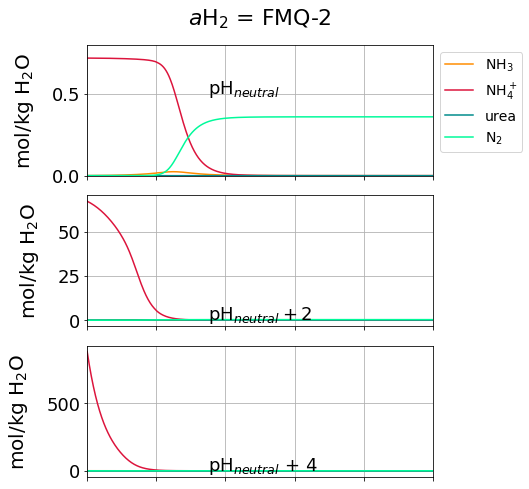

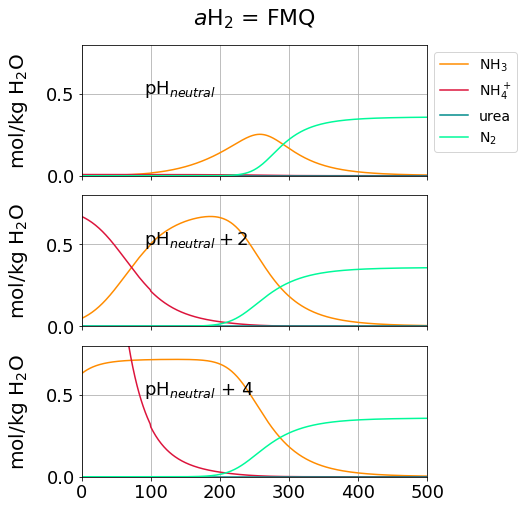

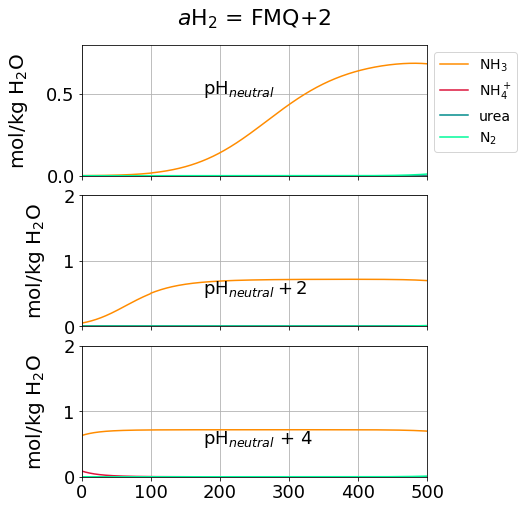

In [66]:
#Plot only species in major species list:
#1. Individual plots:
fig2 = plt.figure(2)
ax = plt.subplot(311) 
for species_name in major_species:
     plt.plot(T,nitrogen_species[species_name][0,0], label = nitrogen_species[species_name + '_l'], color = nitrogen_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,0.8)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 0.5, r'pH$_{neutral}$',size = 18)

plt.legend(bbox_to_anchor=(1,1), prop={'size': 14})
plt.title(r'$a$H$_2$ = FMQ-2')

ax = plt.subplot(312) 
for species_name in major_species:
    plt.plot(T,nitrogen_species[species_name][0,1], label = nitrogen_species[species_name + '_l'], color = nitrogen_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
#plt.ylim(0,0.8)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 0.5, r'pH$_{neutral} + 2$',size = 18)

ax = plt.subplot(313) 
for species_name in major_species:
    plt.plot(T,nitrogen_species[species_name][0,2], label = nitrogen_species[species_name + '_l'], color = nitrogen_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
#plt.ylim(0,0.8)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 0.5, r'pH$_{neutral}$ + 4',size = 18)


plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Nitrogen/FMQ-2_1500bar.png', bbox_inches = 'tight')



fig3 = plt.figure(3)
ax = plt.subplot(311) 
for species_name in major_species:
     plt.plot(T,nitrogen_species[species_name][1,0], label = nitrogen_species[species_name + '_l'], color = nitrogen_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,0.8)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(90, 0.5, r'pH$_{neutral}$',size = 18)

plt.legend(bbox_to_anchor=(1,1), prop={'size': 14})
plt.title(r'$a$H$_2$ = FMQ')

ax = plt.subplot(312) 
for species_name in major_species:
    plt.plot(T,nitrogen_species[species_name][1,1], label = nitrogen_species[species_name + '_l'], color = nitrogen_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,0.8)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(90, 0.5, r'pH$_{neutral} + 2$',size = 18)

ax = plt.subplot(313) 
for species_name in major_species:
    plt.plot(T,nitrogen_species[species_name][1,2], label = nitrogen_species[species_name + '_l'], color = nitrogen_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,0.8)
#plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(90, 0.5, r'pH$_{neutral}$ + 4',size = 18)


plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Nitrogen/FMQ_1500bar.png', bbox_inches = 'tight')



fig4 = plt.figure(4)
ax = plt.subplot(311) 
for species_name in major_species:
     plt.plot(T,nitrogen_species[species_name][2,0], label = nitrogen_species[species_name + '_l'], color = nitrogen_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,0.8)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 0.5, r'pH$_{neutral}$',size = 18)

plt.legend(bbox_to_anchor=(1,1), prop={'size': 14})
plt.title(r'$a$H$_2$ = FMQ+2')

ax = plt.subplot(312) 
for species_name in major_species:
    plt.plot(T,nitrogen_species[species_name][2,1], label = nitrogen_species[species_name + '_l'], color = nitrogen_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,2)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 0.5, r'pH$_{neutral} + 2$',size = 18)

ax = plt.subplot(313) 
for species_name in major_species:
    plt.plot(T,nitrogen_species[species_name][2,2], label = nitrogen_species[species_name + '_l'], color = nitrogen_species[species_name + '_c'])
plt.ylabel('mol/kg H$_2$O')
plt.xlim(0, 500)
plt.ylim(0,2)
#plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.text(175, 0.5, r'pH$_{neutral}$ + 4',size = 18)


plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
plt.show()
plt.savefig('Speciation_Plots/Nitrogen/FMQ+2_1500bar.png', bbox_inches = 'tight')

ValueError: x and y must have same first dimension, but have shapes (501,) and (3, 501)

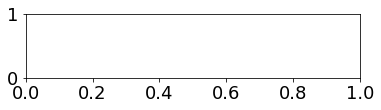

In [70]:
fig2 = plt.figure(2)

ax = plt.subplot(311) 
plt.plot(T,N2[0], label = 'N$_2$')
plt.plot(T,NH3[0], label = 'NH$_3$')
plt.plot(T,NH4[0], label = 'NH$_4^+$')
#plt.plot(T,CO3[0], label = 'CO$_3^{-2}$')
plt.ylabel('Fraction of N')
plt.xlim(250, 750)
plt.ylim(0,1.05)
plt.setp(ax.get_xticklabels(), visible=False)
#plt.legend(bbox_to_anchor=(0.98,0.5), prop={'size': 16})
#plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
plt.grid()
plt.legend(prop={'size': 14})
plt.text(450, 0.5, r'pH$_{neutral}$ - 2',size = 18)
#plt.title(r'FMQ buffer and pH$_{neutral}$')
plt.title(r'$a$H$_2$ = FMQ')
#plt.savefig('logH2_FMQNeutral.png')

ax = plt.subplot(312) 
plt.plot(T,N2[1])
plt.plot(T,NH3[1])
plt.plot(T,NH4[1])
#plt.plot(T,CO3[1], label = 'CO$_3^{-2}$')
#plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('Fraction of N')
plt.xlim(250, 750)
plt.ylim(0,1.05)
plt.setp(ax.get_xticklabels(), visible=False)
#plt.legend(bbox_to_anchor=(0.98,0.5), prop={'size': 16})
#plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
plt.grid()
#plt.legend(prop={'size': 14})
plt.text(450, 0.5, r'pH$_{neutral}$',size = 18)
#plt.title(r'FMQ buffer and pH$_{neutral}$')
#plt.savefig('logH2_FMQNeutral.png')

ax = plt.subplot(313) 
plt.plot(T,N2[2])
plt.plot(T,NH3[2])
plt.plot(T,NH4[2])
#plt.plot(T,CO3[2], label = 'CO$_3^{-2}$')
plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('Fraction of N')
plt.text(450, 0.5, r'pH$_{neutral}$ + 2',size = 18)
plt.xlim(250, 750)
plt.ylim(0,1.05)
plt.grid()
#plt.legend(bbox_to_anchor=(0.98,0.5), prop={'size': 16})
#plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
#plt.savefig('logH2_FMQNeutral.png')
plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Nitrogen/FMQ_1500bar.png', bbox_inches = 'tight')

In [71]:
#mole fractions - all WRT N2 - FMQ
X_NH3 = np.zeros([3,len(T)])
X_NH4 = np.zeros([3,len(T)])
#X_CO3 = np.zeros([3,len(T)])
N2 = np.zeros([3,len(T)]) 
NH3 = np.zeros([3,len(T)])
NH4 = np.zeros([3,len(T)])
#CO3 = np.zeros([3,len(T)]) 
for i in range(0, 3):
    X_NH3[i] = ((10**aH2[0])**3)/((10**K_NH3)*(1/3)*Sigma_N)
    X_NH4[i] = ((10**aH2[0])**3)*((10**-pH[i])**2)/((10**K_NH4)*(1/3)*Sigma_N)
    #X_CO3[i] = (10**K_CO3)/(((10**-pH[i])**2)*((10**aH2[0])**4))
    N2[i] = 2/(2 + X_NH3[i] + X_NH4[i])
    NH3[i,:] = X_NH3[i,:]*N2[i,:]
    NH4[i,:] = X_NH4[i,:]*N2[i,:]
    #CO3[i,:] = X_CO3[i,:]*X_CH4[i,:]

fig3 = plt.figure(3)

ax = plt.subplot(311) 
plt.plot(T,N2[0], label = 'N$_2$')
plt.plot(T,NH3[0], label = 'NH$_3$')
plt.plot(T,NH4[0], label = 'NH$_4^+$')
#plt.plot(T,CO3[0], label = 'CO$_3^{-2}$')
plt.ylabel('Fraction of N')
plt.xlim(250, 750)
plt.ylim(0,1.05)
plt.setp(ax.get_xticklabels(), visible=False)
#plt.legend(bbox_to_anchor=(0.98,0.5), prop={'size': 16})
#plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
plt.grid()
plt.legend(prop={'size': 14})
plt.text(450, 0.5, r'pH$_{neutral}$ - 2',size = 18)
#plt.title(r'FMQ buffer and pH$_{neutral}$')
plt.title(r'$a$H$_2$ = FMQ-2')
#plt.savefig('logH2_FMQNeutral.png')

ax = plt.subplot(312) 
plt.plot(T,N2[1])
plt.plot(T,NH3[1])
plt.plot(T,NH4[1])
#plt.plot(T,CO3[0], label = 'CO$_3^{-2}$')
#plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('Fraction of N')
plt.xlim(250, 750)
plt.ylim(0,1.05)
plt.setp(ax.get_xticklabels(), visible=False)
#plt.legend(bbox_to_anchor=(0.98,0.5), prop={'size': 16})
#plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
plt.grid()
#plt.legend(prop={'size': 14})
plt.text(450, 0.5, r'pH$_{neutral}$',size = 18)
#plt.title(r'FMQ buffer and pH$_{neutral}$')
#plt.savefig('logH2_FMQNeutral.png')

ax = plt.subplot(313) 
plt.plot(T,N2[2])
plt.plot(T,NH3[2])
plt.plot(T,NH4[2])
#plt.plot(T,CO3[2], label = 'CO$_3^{-2}$')
plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('Fraction of N')
plt.text(450, 0.5, r'pH$_{neutral}$ + 2',size = 18)
plt.xlim(250, 750)
plt.ylim(0,1.05)
plt.grid()
#plt.legend(bbox_to_anchor=(0.98,0.5), prop={'size': 16})
#plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
#plt.savefig('logH2_FMQNeutral.png')
plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Nitrogen/FMQ-2_1500bar.png', bbox_inches = 'tight')

NameError: name 'K_NH3' is not defined

In [35]:
#mole fractions - all WRT N2 - FMQ
X_NH3 = np.zeros([3,len(T)])
X_NH4 = np.zeros([3,len(T)])
#X_CO3 = np.zeros([3,len(T)])
N2 = np.zeros([3,len(T)]) 
NH3 = np.zeros([3,len(T)])
NH4 = np.zeros([3,len(T)])
#CO3 = np.zeros([3,len(T)]) 
for i in range(0, 3):
    X_NH3[i] = ((10**aH2[2])**3)/((10**K_NH3)*(1/3)*Sigma_N)
    X_NH4[i] = ((10**aH2[2])**3)*((10**-pH[i])**2)/((10**K_NH4)*(1/3)*Sigma_N)
    #X_CO3[i] = (10**K_CO3)/(((10**-pH[i])**2)*((10**aH2[2])**4))
    N2[i] = 1/(1 + X_NH3[i] + X_NH4[i])
    NH3[i,:] = X_NH3[i,:]*N2[i,:]
    NH4[i,:] = X_NH4[i,:]*N2[i,:]
    #CO3[i,:] = X_CO3[i,:]*X_CH4[i,:]

fig3 = plt.figure(3)

ax = plt.subplot(311) 
plt.plot(T,N2[0], label = 'N$_2$')
plt.plot(T,NH3[0], label = 'NH$_3$')
plt.plot(T,NH4[0], label = 'NH$_4^+$')
#plt.plot(T,CO3[2], label = 'CO$_3^{-2}$')
plt.ylabel('Fraction of N')
plt.xlim(250, 750)
plt.ylim(0,1.05)
plt.setp(ax.get_xticklabels(), visible=False)
plt.grid()
plt.legend(bbox_to_anchor=(0.3,0.5),prop={'size': 14})
plt.text(425, 0.5, r'pH$_{neutral}$ - 2',size = 18)
plt.title(r'$a$H$_2$ = FMQ+2')

ax = plt.subplot(312) 
plt.plot(T,N2[1])
plt.plot(T,NH3[1])
plt.plot(T,NH4[1])
#plt.plot(T,CO3[2], label = 'CO$_3^{-2}$')
#plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('Fraction of N')
plt.xlim(250, 750)
plt.ylim(0,1.05)
plt.setp(ax.get_xticklabels(), visible=False)
#plt.legend(bbox_to_anchor=(0.98,0.5), prop={'size': 16})
#plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
plt.grid()
#plt.legend(prop={'size': 14})
plt.text(425, 0.5, r'pH$_{neutral}$',size = 18)
#plt.title(r'FMQ buffer and pH$_{neutral}$')
#plt.savefig('logH2_FMQNeutral.png')

ax = plt.subplot(313) 
plt.plot(T,N2[2])
plt.plot(T,NH3[2])
plt.plot(T,NH4[2])
#plt.plot(T,CO3[2], label = 'CO$_3^{-2}$')
plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('Fraction of N')
plt.text(425, 0.5, r'pH$_{neutral}$ + 2',size = 18)
plt.xlim(250, 750)
plt.ylim(0,1.05)
plt.grid()
#plt.legend(bbox_to_anchor=(0.98,0.5), prop={'size': 16})
#plt.subplots_adjust(left=0.12, right=0.93, top=0.8, bottom=0.15)
#plt.savefig('logH2_FMQNeutral.png')
plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.show()
plt.savefig('Speciation_Plots/Nitrogen/FMQ+2_1500bar.png', bbox_inches = 'tight')

NameError: name 'K_NH3' is not defined

ValueError: x and y must have same first dimension, but have shapes (927,) and (66,)

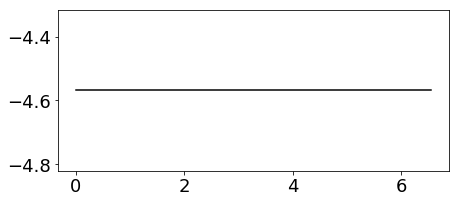

In [36]:
#Abstract Plots:
#T = 500
fig1 = plt.figure(1)
fig1.set_figheight(6.5)
fig1.set_figwidth(7)


ax = plt.subplot(211)
#CH4 -> CO2
plt.plot([0,pH_5[2]],[aH2_1[2],aH2_1[2]], label = r'CH$_4 \rightarrow$ CO$_2$', color = 'k')
#CH4 -> HCO3
pH_2 = pH[pH>x_12[2]]
aH2_2_new = aH2_2[2][aH2_2[2]>y_12[2]]
plt.plot(pH_2[pH_2<x_23[2]], aH2_2_new[aH2_2_new<y_23[2]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CH4 -> HCO3
plt.plot(pH[pH>x_23[2]], aH2_3[2][aH2_3[2]>y_23[2]], label = r'CH$_4 \rightarrow$ HCO$_3$', color = 'k')
#CO2 -> HCO3
plt.plot([pH_5[2], pH_5[2]], [-7,aH2_1[2]], label = r'CO$_2 \rightarrow$ HCO$_3^-$', color = 'k')
#HCO3 -> CO3-2
plt.plot([pH_6[2], pH_6[2]], [-7,y_23[2]], label = r'HCO$_3 \rightarrow$ CO$_3^-$', color = 'k')
#Labels:
plt.text(6.5,0.5, 'CH$_4$', size=22)
plt.text(4.5,-3.5, 'CO$_2$', size=22)
plt.text(10.4,-3, 'HCO$_3^-$', size=22, rotation=90)
plt.text(12.3,-3, 'CO$_3^{-2}$', size=22, rotation=90)
plt.text(0.5, -5.5, 'T = 500$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
#FMQ buffer
plt.axhline(y=FMQ_500,linestyle='--')
plt.text(1,-1.5,'FMQ Buffer', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_500, linestyle = ':', color = 'darkorchid')
plt.text(4.9,1.5,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,2)
plt.ylabel('log($a$H$_2$)')
#plt.legend(prop={'size': 16})
#plt.grid()
#plt.show()
#plt.savefig('Speciation_Plots/Carbon/activity_500', bbox_inches = 'tight')


#T = 500
ax = plt.subplot(212)
#N2 -> NH3]
plt.plot([pH_3[2],14],[aH2_1[2],aH2_1[2]], label = r'N$_2 \rightarrow$ NH$_3$', color = 'k')
#N2 -> NH4
plt.plot(pH[pH<pH_3[2]], aH2_2[2][aH2_2[2]<aH2_1[2]], label = r'N$_2 \rightarrow$ NH$_4$', color = 'k')
#plt.plot(pH, aH2_2[2], label = r'N$_2 \rightarrow$ NH$_4$')#, color = 'k')
# #NH3 - NH4
plt.plot([pH_3[2],pH_3[2]], [aH2_1[2],3], label = r'NH$_3 \rightarrow$ NH$_4$', color = 'k')
#Labels:
plt.text(7,-3, 'N$_2$', size=22)
plt.text(1,0.5, 'NH$_4^+$', size=22)
plt.text(8,1.5, 'NH$_3$', size=22)
# plt.text(11.75,-3.5, 'CO$_3^{-2}$', size=22, rotation=90)
#FMQ buffer
plt.axhline(y=FMQ_500,linestyle='--')
plt.text(10,-1,'FMQ Buffer', size=16, color = '#1f77b4')
#pH neutral
plt.axvline(x=pHn_500, linestyle = ':', color = 'darkorchid')
plt.text(4.8,-2,'pH neutral', size=16, color = 'darkorchid', rotation = 90)
#T & P label:
plt.text(8.5, -5.5, 'T = 500$\degree$C \nP = 1500 bar', size = 20, bbox=dict(facecolor='blue', alpha=0.3))
plt.xlim(0,14)
plt.xlabel('pH')
plt.ylim(-6,3)
plt.ylabel('log($a$H$_2$)')
#plt.legend(prop={'size': 16})
#plt.grid()


plt.subplots_adjust(left = 1.0, bottom=2.5, right=1.8, top=4,
                 wspace=0.07, hspace=0.15)
#plt.savefig('Speciation_Plots/Nitrogen/activity_500', bbox_inches = 'tight')
plt.show()